# Comparing proposed congressional district plans in North Carolina

November 20, 2019

### new version

With the redistricting process happening right now, there have been several proposed maps. These files are released to the public via [ncleg.gov](). 

This tutorial demonstrates two separate functionalities:
1. How to read in multiple shapefiles for quick comparison
2. How to use geopandas dataframes 

Part (1) is intended to show how to go from zipped files that may be posted on a state's legislative website into geopandas dataframes, which can then be worked with further in part (2). If you would just like to use the shapefiles I've used, you can skip part (1) and just use the data I've uploaded to this repository directly. 

Add motivation at the top about why it’s important to compare maps. That will help answer the “why is this important?” question, which is a good place to start all code and reports. (Note – realized after our group meeting that this might not be important if embedded within the journalists report. If so, include some words about how visual representations of information can help readers understand things in new ways)

This notebook demonstrates how to:
1. Read in multiple shapefiles, each of which represents a proposed congressional district plan
2. Aggregate US House votes from 2018 into the appropriate district to see the resulting (theoretical) democratic vote share of each district (if this plan had been used in 2018)
3. Create a PDF file of all vote share maps to easily compare

First make sure you have all required packages installed and imported.

In [1]:
import maup
import geopandas as gpd
import pandas as pd
import os
import shutil
import numpy as np
from PyPDF2 import PdfFileMerger, PdfFileReader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import gerrymetrics as g

Dowload 2018 election results (at the precinct level) from https://github.com/mggg-states/NC-shapefiles. Unzip the "NC_VTD.zip" files to access the .shp file.

In [6]:
os.getcwd()

'/Users/rachelwitner/Documents/PGP/NC_redistricting'

In [3]:
#load in precincts  shapefile
precincts = gpd.read_file("./data/NC_VTD/NC_G18.shp")

#list variables you want to aggreage into districts
variables = ['G18CStHOR', 'G18CStSen', 'G18CHOR','G18DStHOR', 'G18DStSEN', 'G18DHOR', 'G18GStHOR', 'G18GHOR','G18LStHOR', 'G18LStSEN', 
             'G18LHOR', 'G18RStHOR', 'G18RStSEN','G18RHOR', 'G18UnaHOR']

# view precincts file
precincts.head()

PREC_ID              ENR_DESC COUNTY_NAM OF_PREC_ID  COUNTY_ID  \
0     06N      06N_NORTH GRAHAM   ALAMANCE       None          1   
1    1210    1210_BURLINGTON 10   ALAMANCE       None          1   
2     06E       06E_EAST GRAHAM   ALAMANCE       None          1   
3     063          063_GRAHAM 3   ALAMANCE       None          1   
4     12N  12N_NORTH BURLINGTON   ALAMANCE       None          1   

        loc_prec       prec_shp  G18CStHOR  G18CStSen  G18CHOR  ...  \
0   ALAMANCE,06N   ALAMANCE,06N          0          0        0  ...   
1  ALAMANCE,1210  ALAMANCE,1210          0          0        0  ...   
2   ALAMANCE,06E   ALAMANCE,06E          0          0        0  ...   
3   ALAMANCE,063   ALAMANCE,063          0          0        0  ...   
4   ALAMANCE,12N   ALAMANCE,12N          0          0        0  ...   

   G18GStHOR  G18GHOR  G18LStHOR  G18LStSEN  G18LHOR  G18RStHOR  G18RStSEN  \
0          0        0          0          0        0        312        335   
1          0        0          0          0        0        393        410   
2          0        0          0          0        0        527        566   
3          0        0          0          0        0        365        370   
4          0        0          0          0        0        192        196   

   G18RHOR  G18UnaHOR                                           geometry  
0      344          0  POLYGON ((1884558.649606138 851226.325625971, ...  
1      421          0  POLYGON ((1867094.975872144 842884.0693446398,...  
2      572          0  POLYGON ((1885497.823580801 846796.6756926477,...  
3      386          0  POLYGON ((1885054.110557467 851287.3586403877,...  
4      203          0  POLYGON ((1872167.538561642 854095.3789429814,...  

[5 rows x 23 columns]

# Moving around shapefiles 

I've uploaded all the proposed district maps to the `data` folder of this repository. If you want to use these files, you can **__skip this section and go straight to the next section labeled ___.**

### Skip this section if using data available in this repository

This function enables you to read in a file given the file name and a label to call the plan once it's read in as a Geopandas dataframe. We'll then use a loop to read in all the shapefiles you have saved in a directory. 

To reproduce this, go to https://www.ncleg.gov/Committees/CommitteeInfo/House/182#Documents. Choose a day (e.g. "11-13-19"), choose a plan (e.g. "HB 1029 1st Edition"), then download the file ending with "-Shapefile" and unzip it. Keep all these folders in your Downloads folder to read through. We'll move them to a different folder for permanent access.

I'll also include the current congressional map, which is to be replaced. It can be downloaded from https://www3.ncleg.gov/Representation/Content/Plans/PlanPage_DB_2016.asp?Plan=2016_Contingent_Congressional_Plan_-_Corrected&Body=Congress. At the bottom of this page under "FILES FOR DOWNLOAD", download the zip file next to "District Layer in Shapefile Format". Then unzip and rename this folder so that it ends in "Shapefile" (to match the rest of the downloaded files) and place it in the same Downloads directory.

In [3]:
# function to read in a file with districts and sum votes by district
def load_district_shapefile(fname, label):
    thisfile = gpd.read_file("./data/NC Congressional Redistricting/" + fname)
    thisfile = thisfile.to_crs(precincts.crs)
    
    #make district assignment for every precinct
    assignment = maup.assign(precincts, thisfile)

    #sum votes by district
    thisfile[variables] = precincts[variables].groupby(assignment).sum()
    
    files[label] = thisfile

In [32]:
# move all files from within separate shapefile folders into one folder
destinationFolder = "/Users/rachelwitner/Documents/PGP/data/NC Congressional Redistricting/"
folderList = os.listdir("/Users/rachelwitner/Downloads/")
for folder in folderList:
    if "Shapefile" in folder:
        # move all files in folder to PGP data folder
        files = os.listdir("/Users/rachelwitner/Downloads/" + folder)
        for file in files:
            os.rename("/Users/rachelwitner/Downloads/" + folder + "/" + file, destinationFolder+file)

In [33]:
# create dictionary (files) of district geopandas files
files = {}
fileList = os.listdir("./data/NC Congressional Redistricting")
for file in fileList:
    if file.endswith(".shp"):
        filename = file[:-4]
        load_district_shapefile(file, filename)

Now we can easily work with any of the following district files:

In [34]:
files.keys()

dict_keys(['C-NewtonA-5-4-TC', 'C-HarrisonA-1-TC', 'C-Clark-8-6-TC', 'C-LewisD-1-TC', 'C-Clark-9-6 RN', 'C-HiseC-1-ND', 'C-Farmer-ButterfieldC-1-BK', 'C-McKissickB-1-TC', 'C-Farmer-ButterfieldA-1-3-BK', 'C-LewisD-1-RN', 'C-HiseA-4-1-TC', 'C-HiseA-5-BR', 'C-Clark-8-3-TC', 'C-McKissickA-1-TC', 'C-FloydA-1-ST', '2016_Contingent_Congressional_Plan_Corrected'])

Next we loop through each Geopandas dataframe (which were saved in the dictionary called `files`). For each one, create a colorbar centered at 50% to show the percent democratic vote share for each district, using the 2018 US House election results.

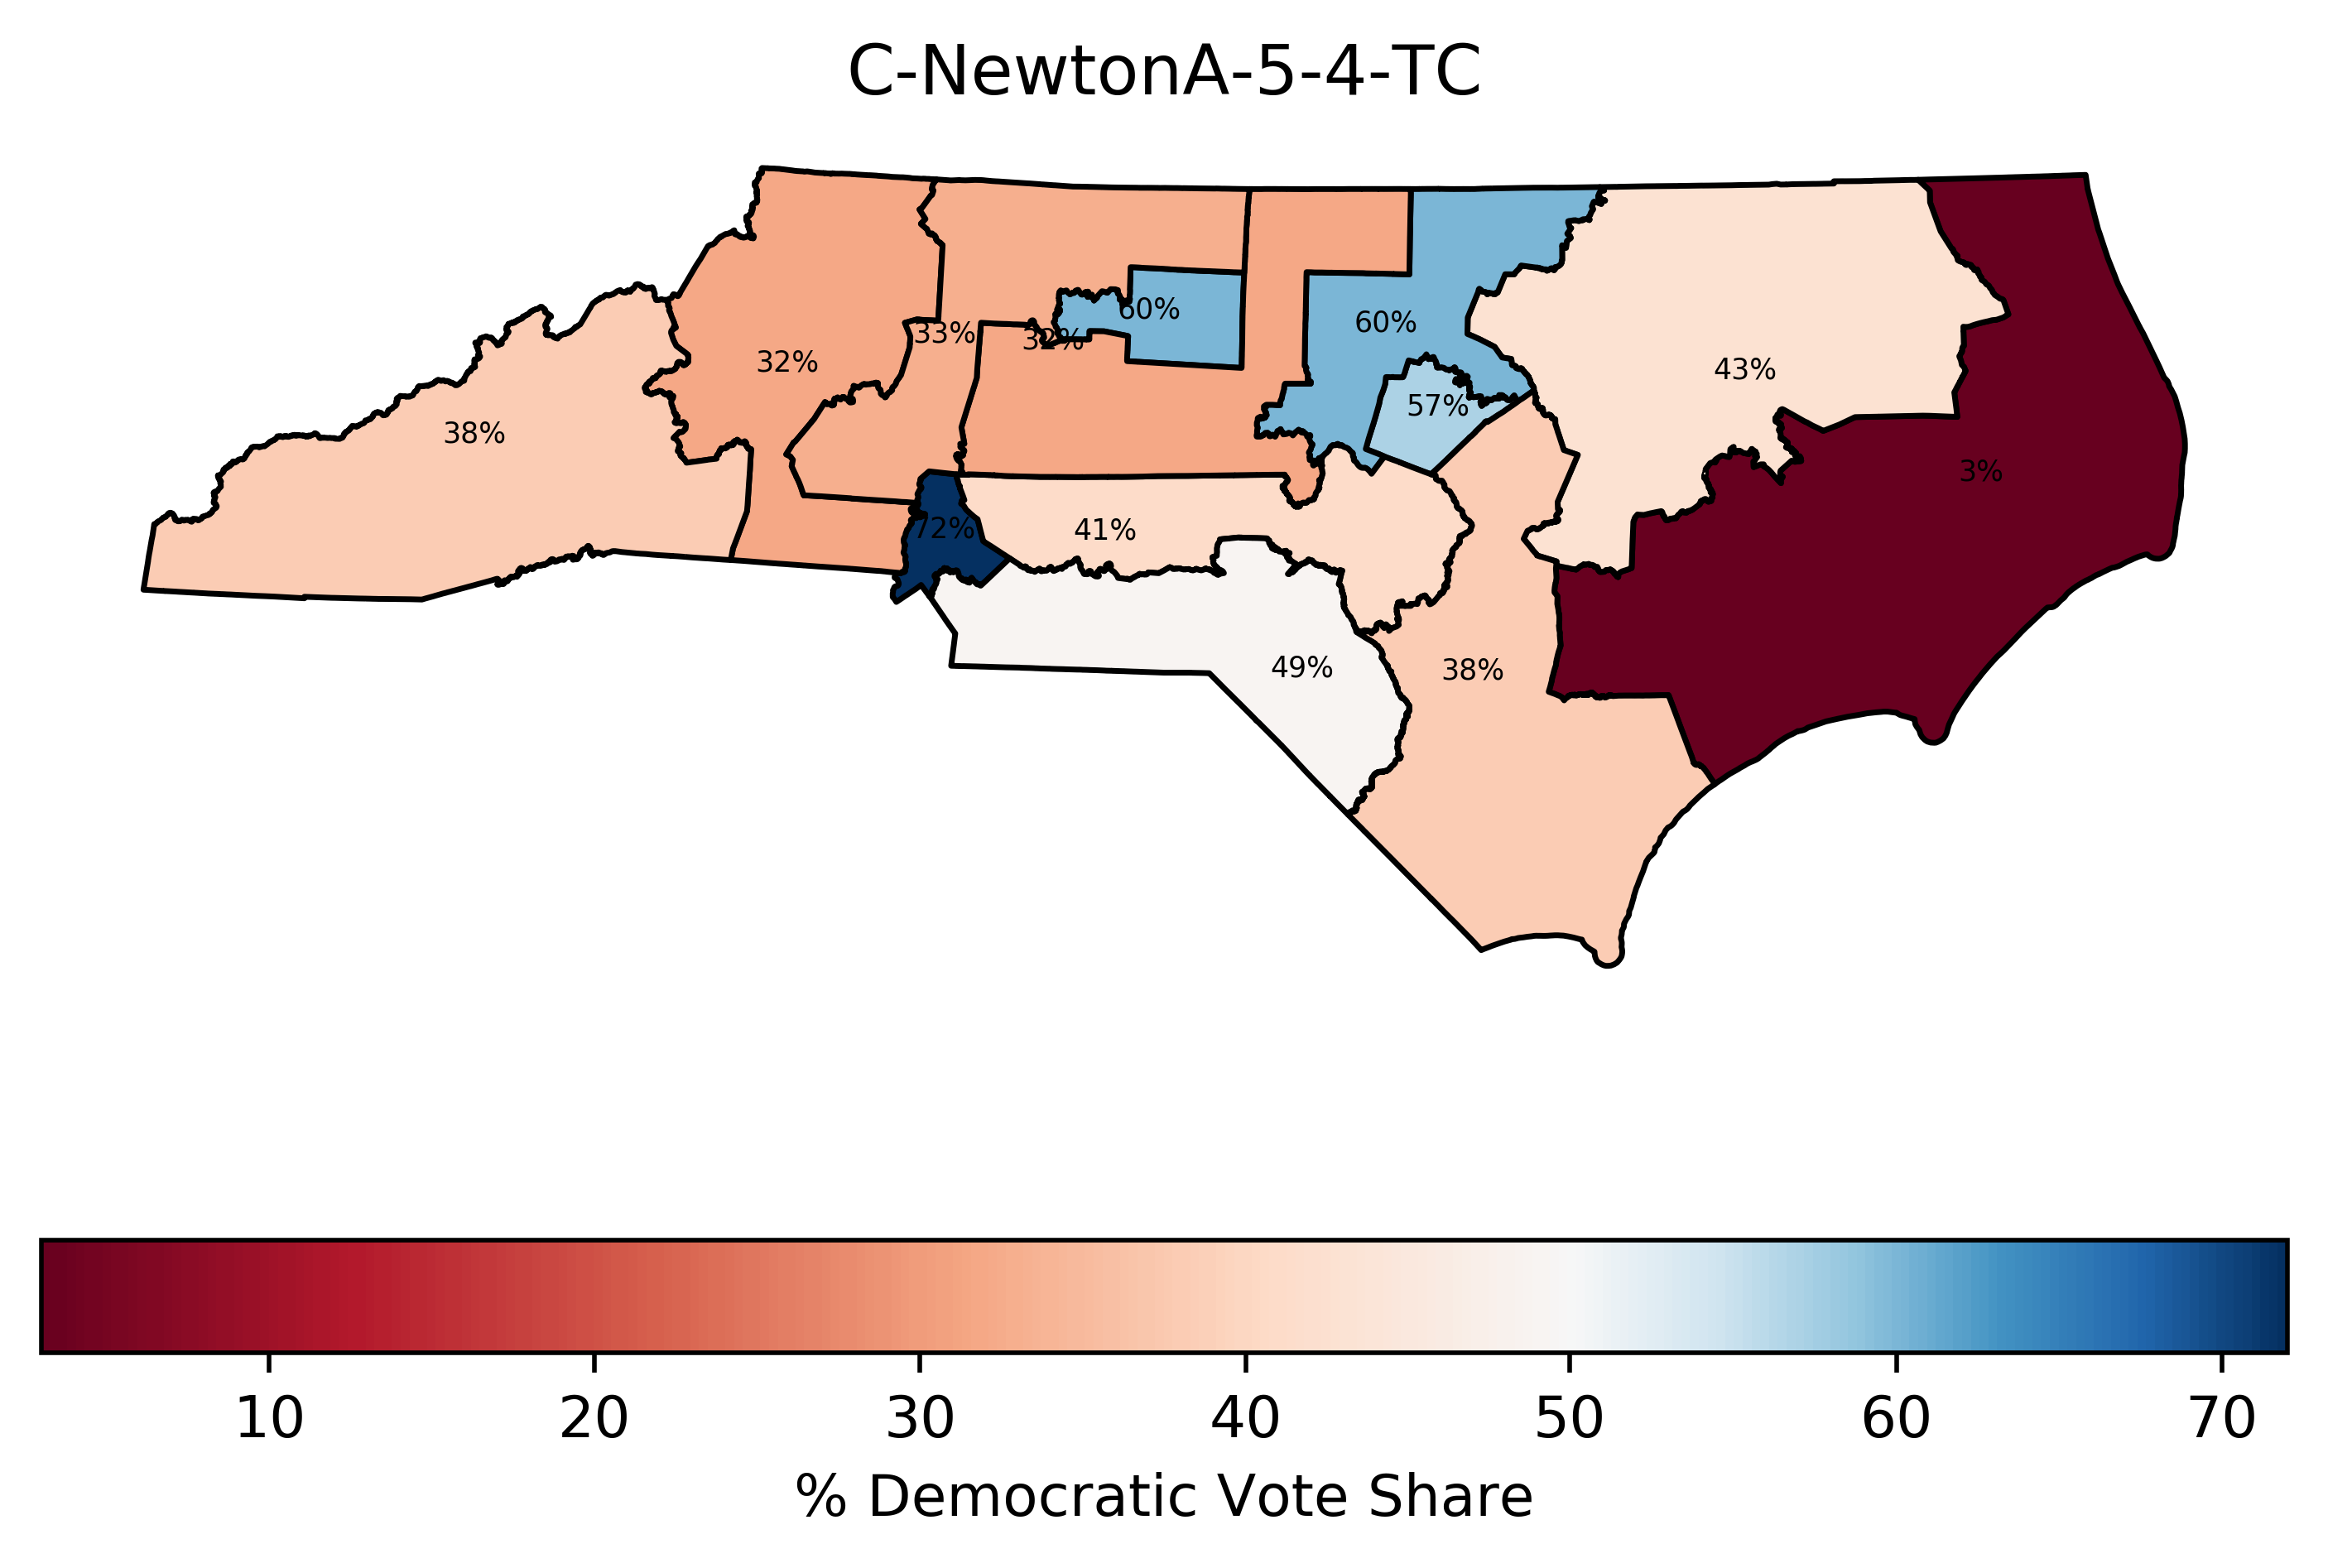

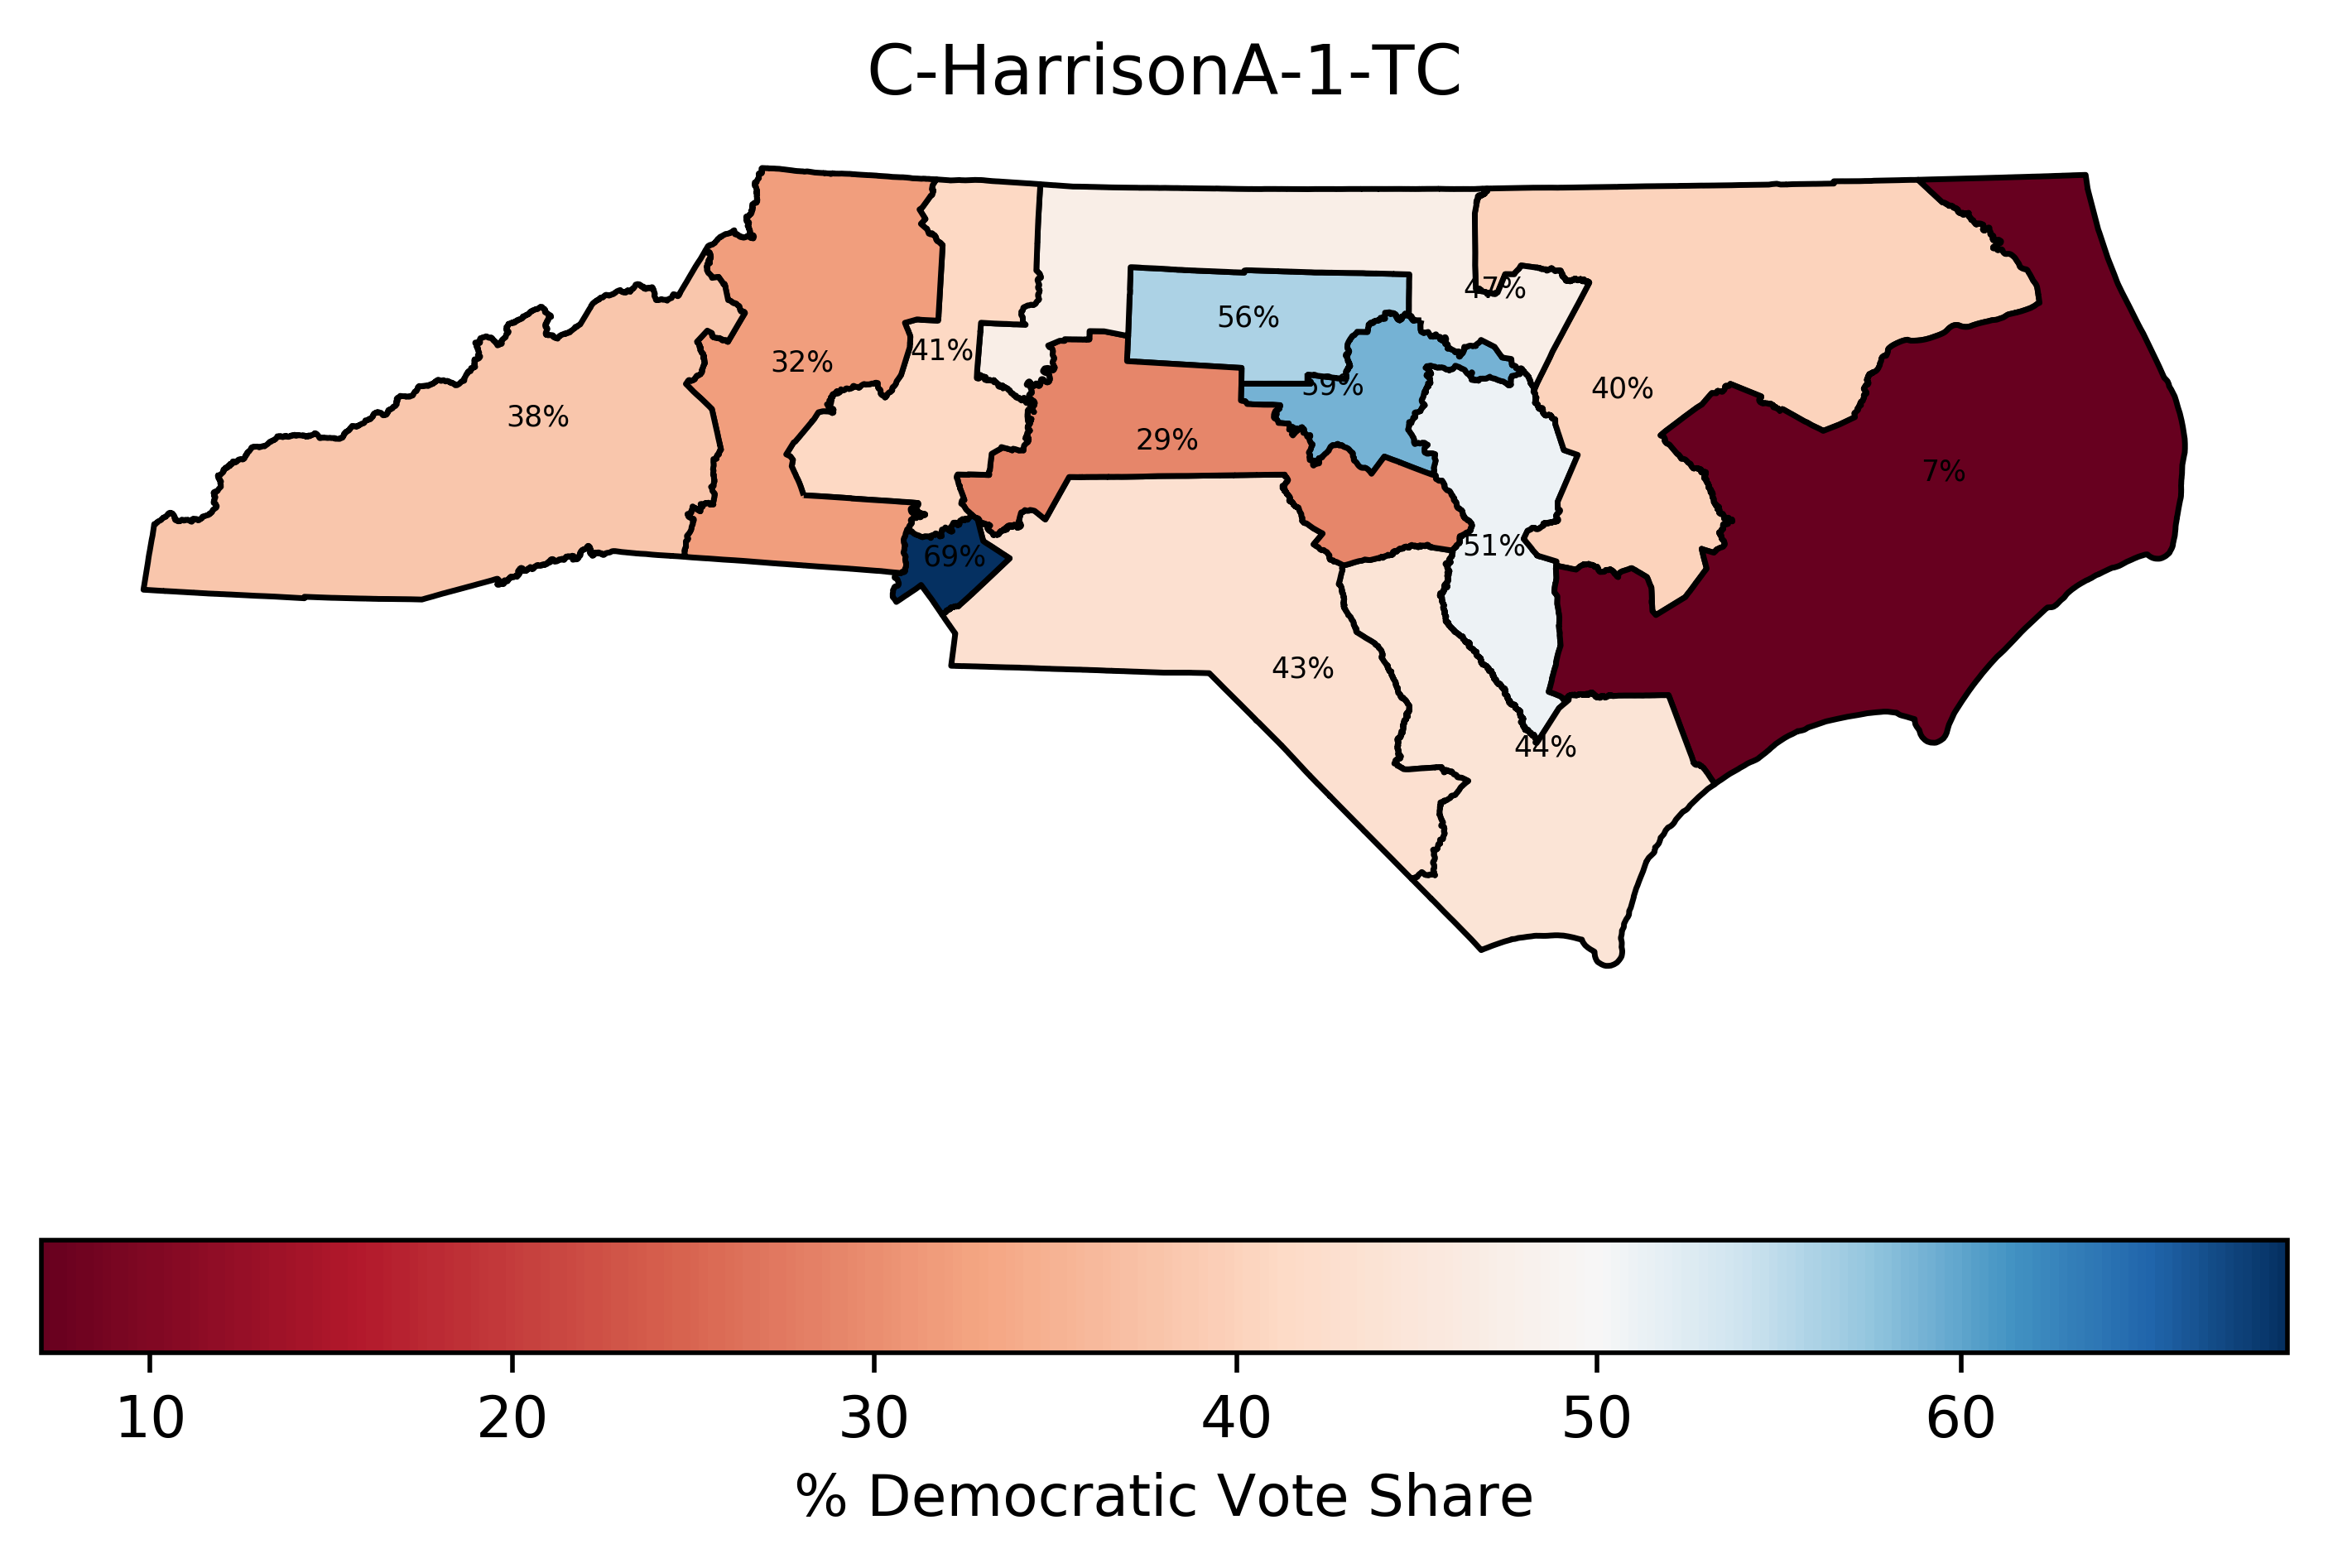

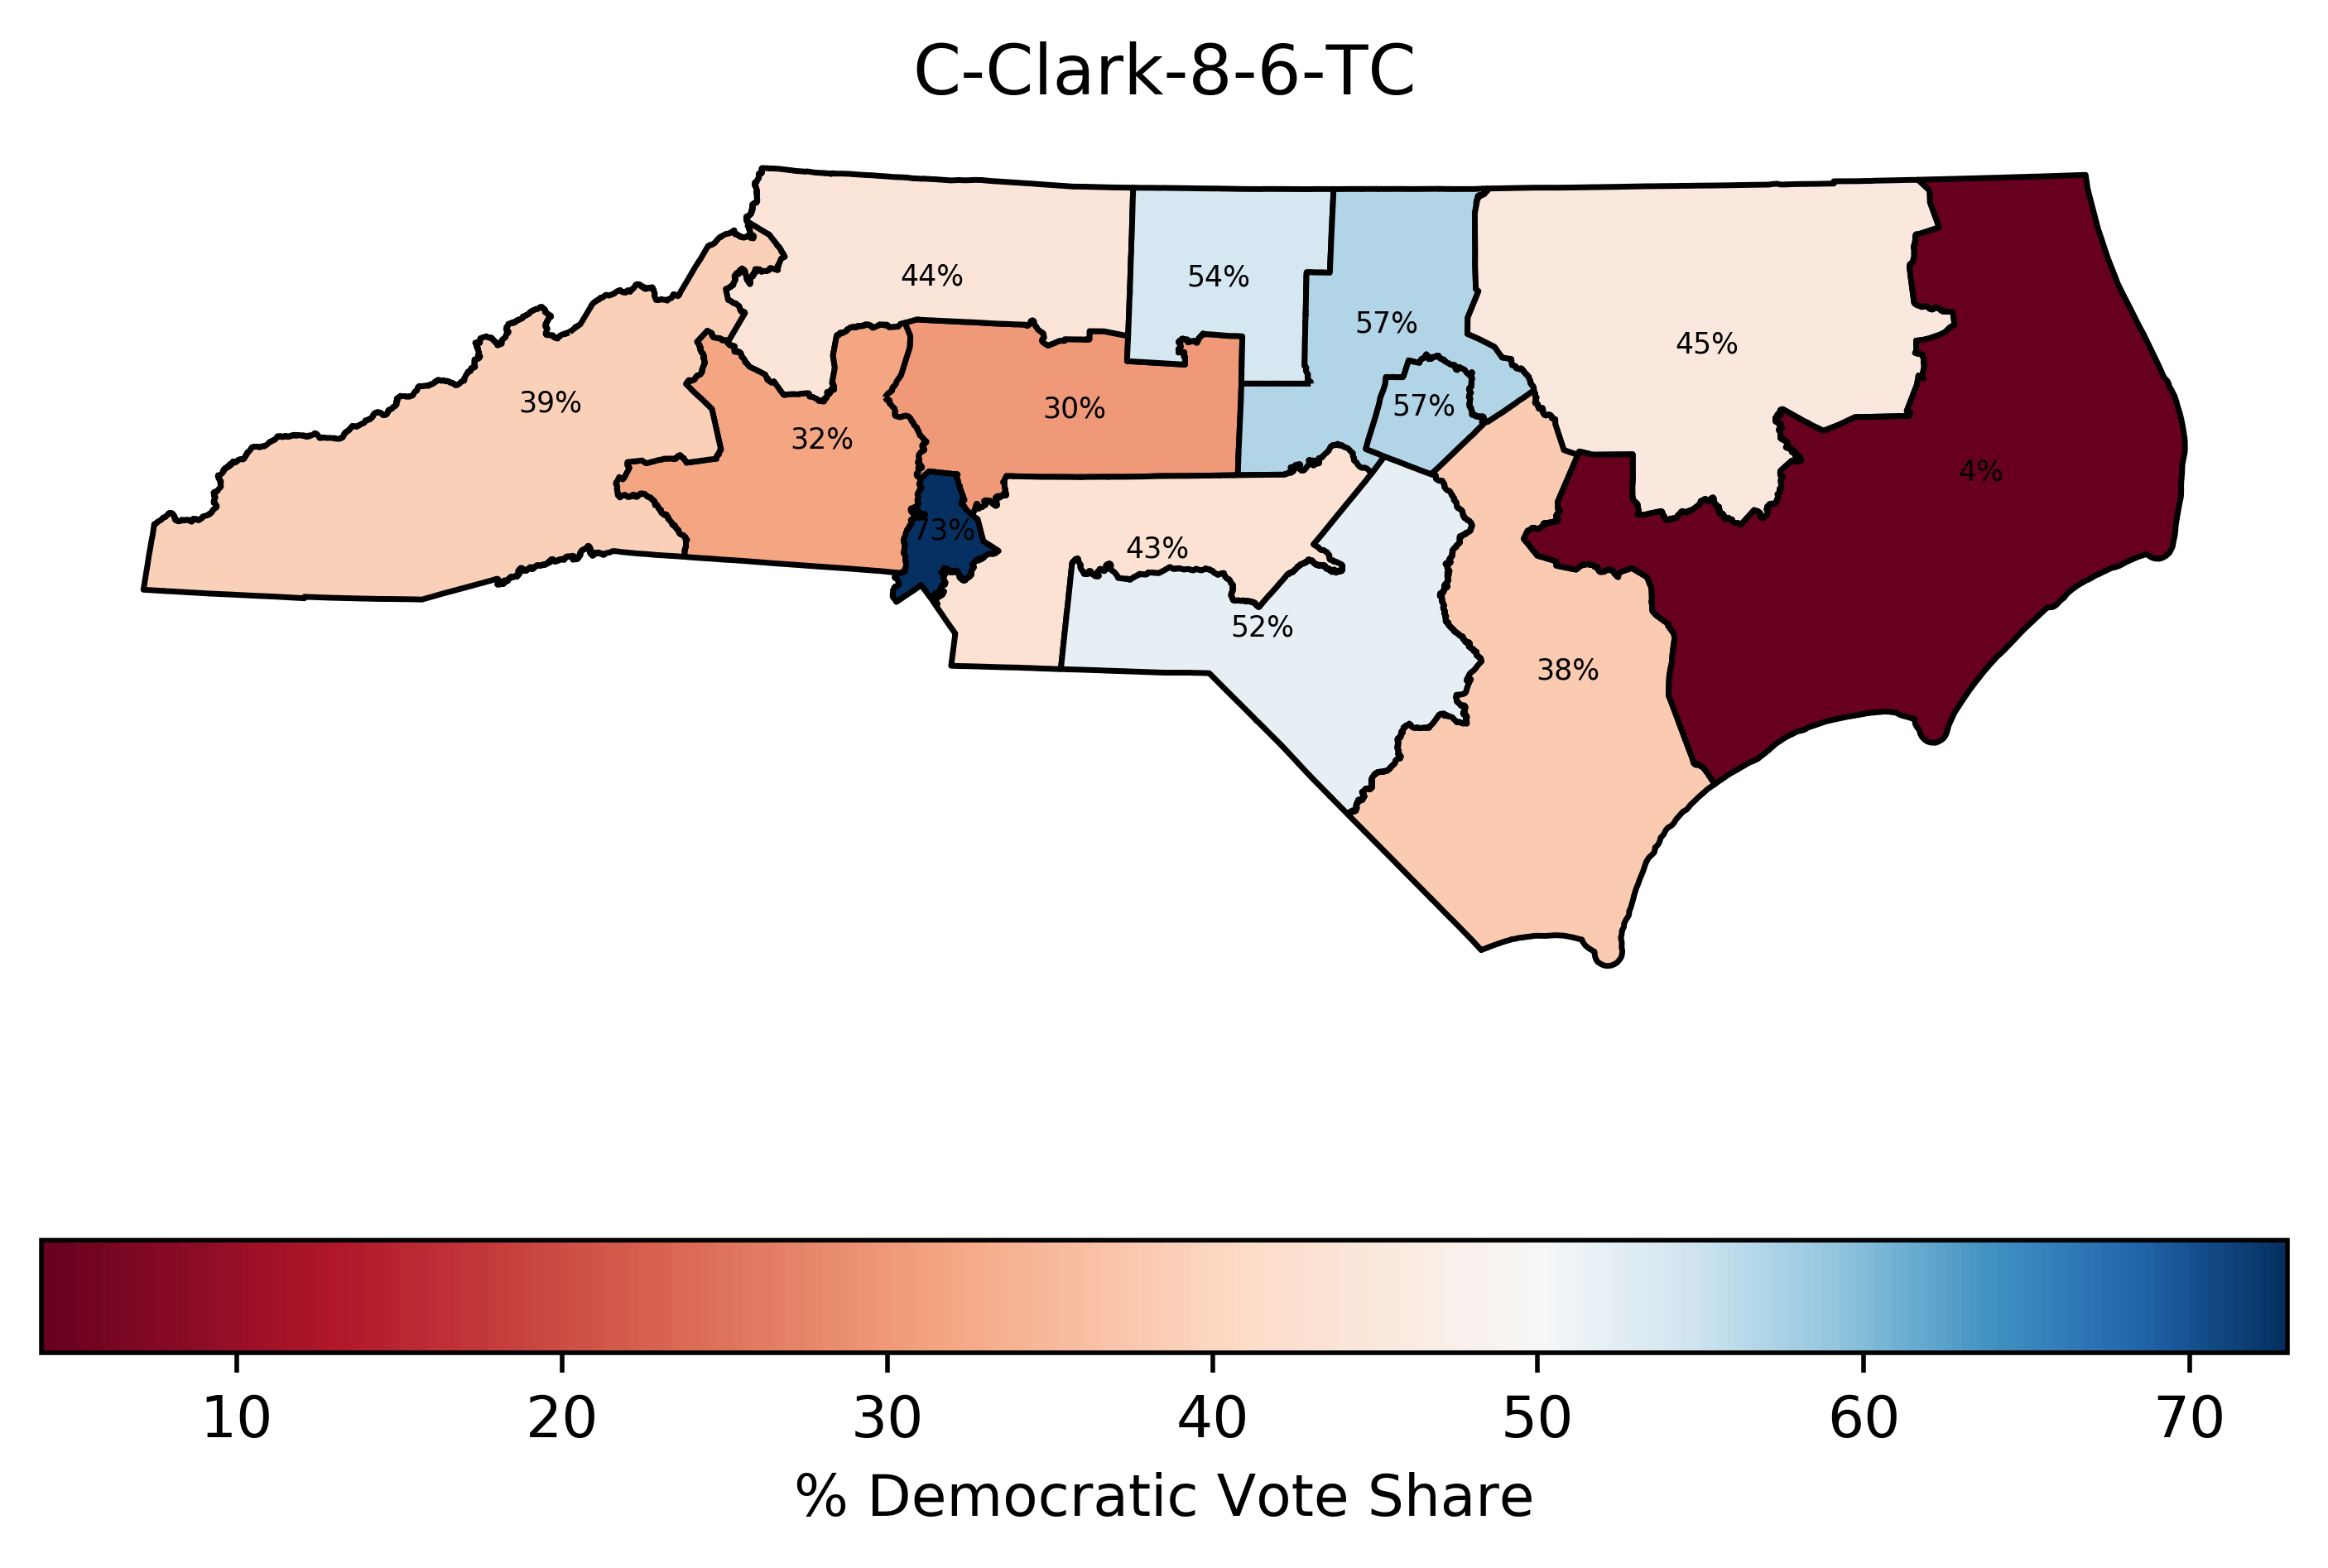

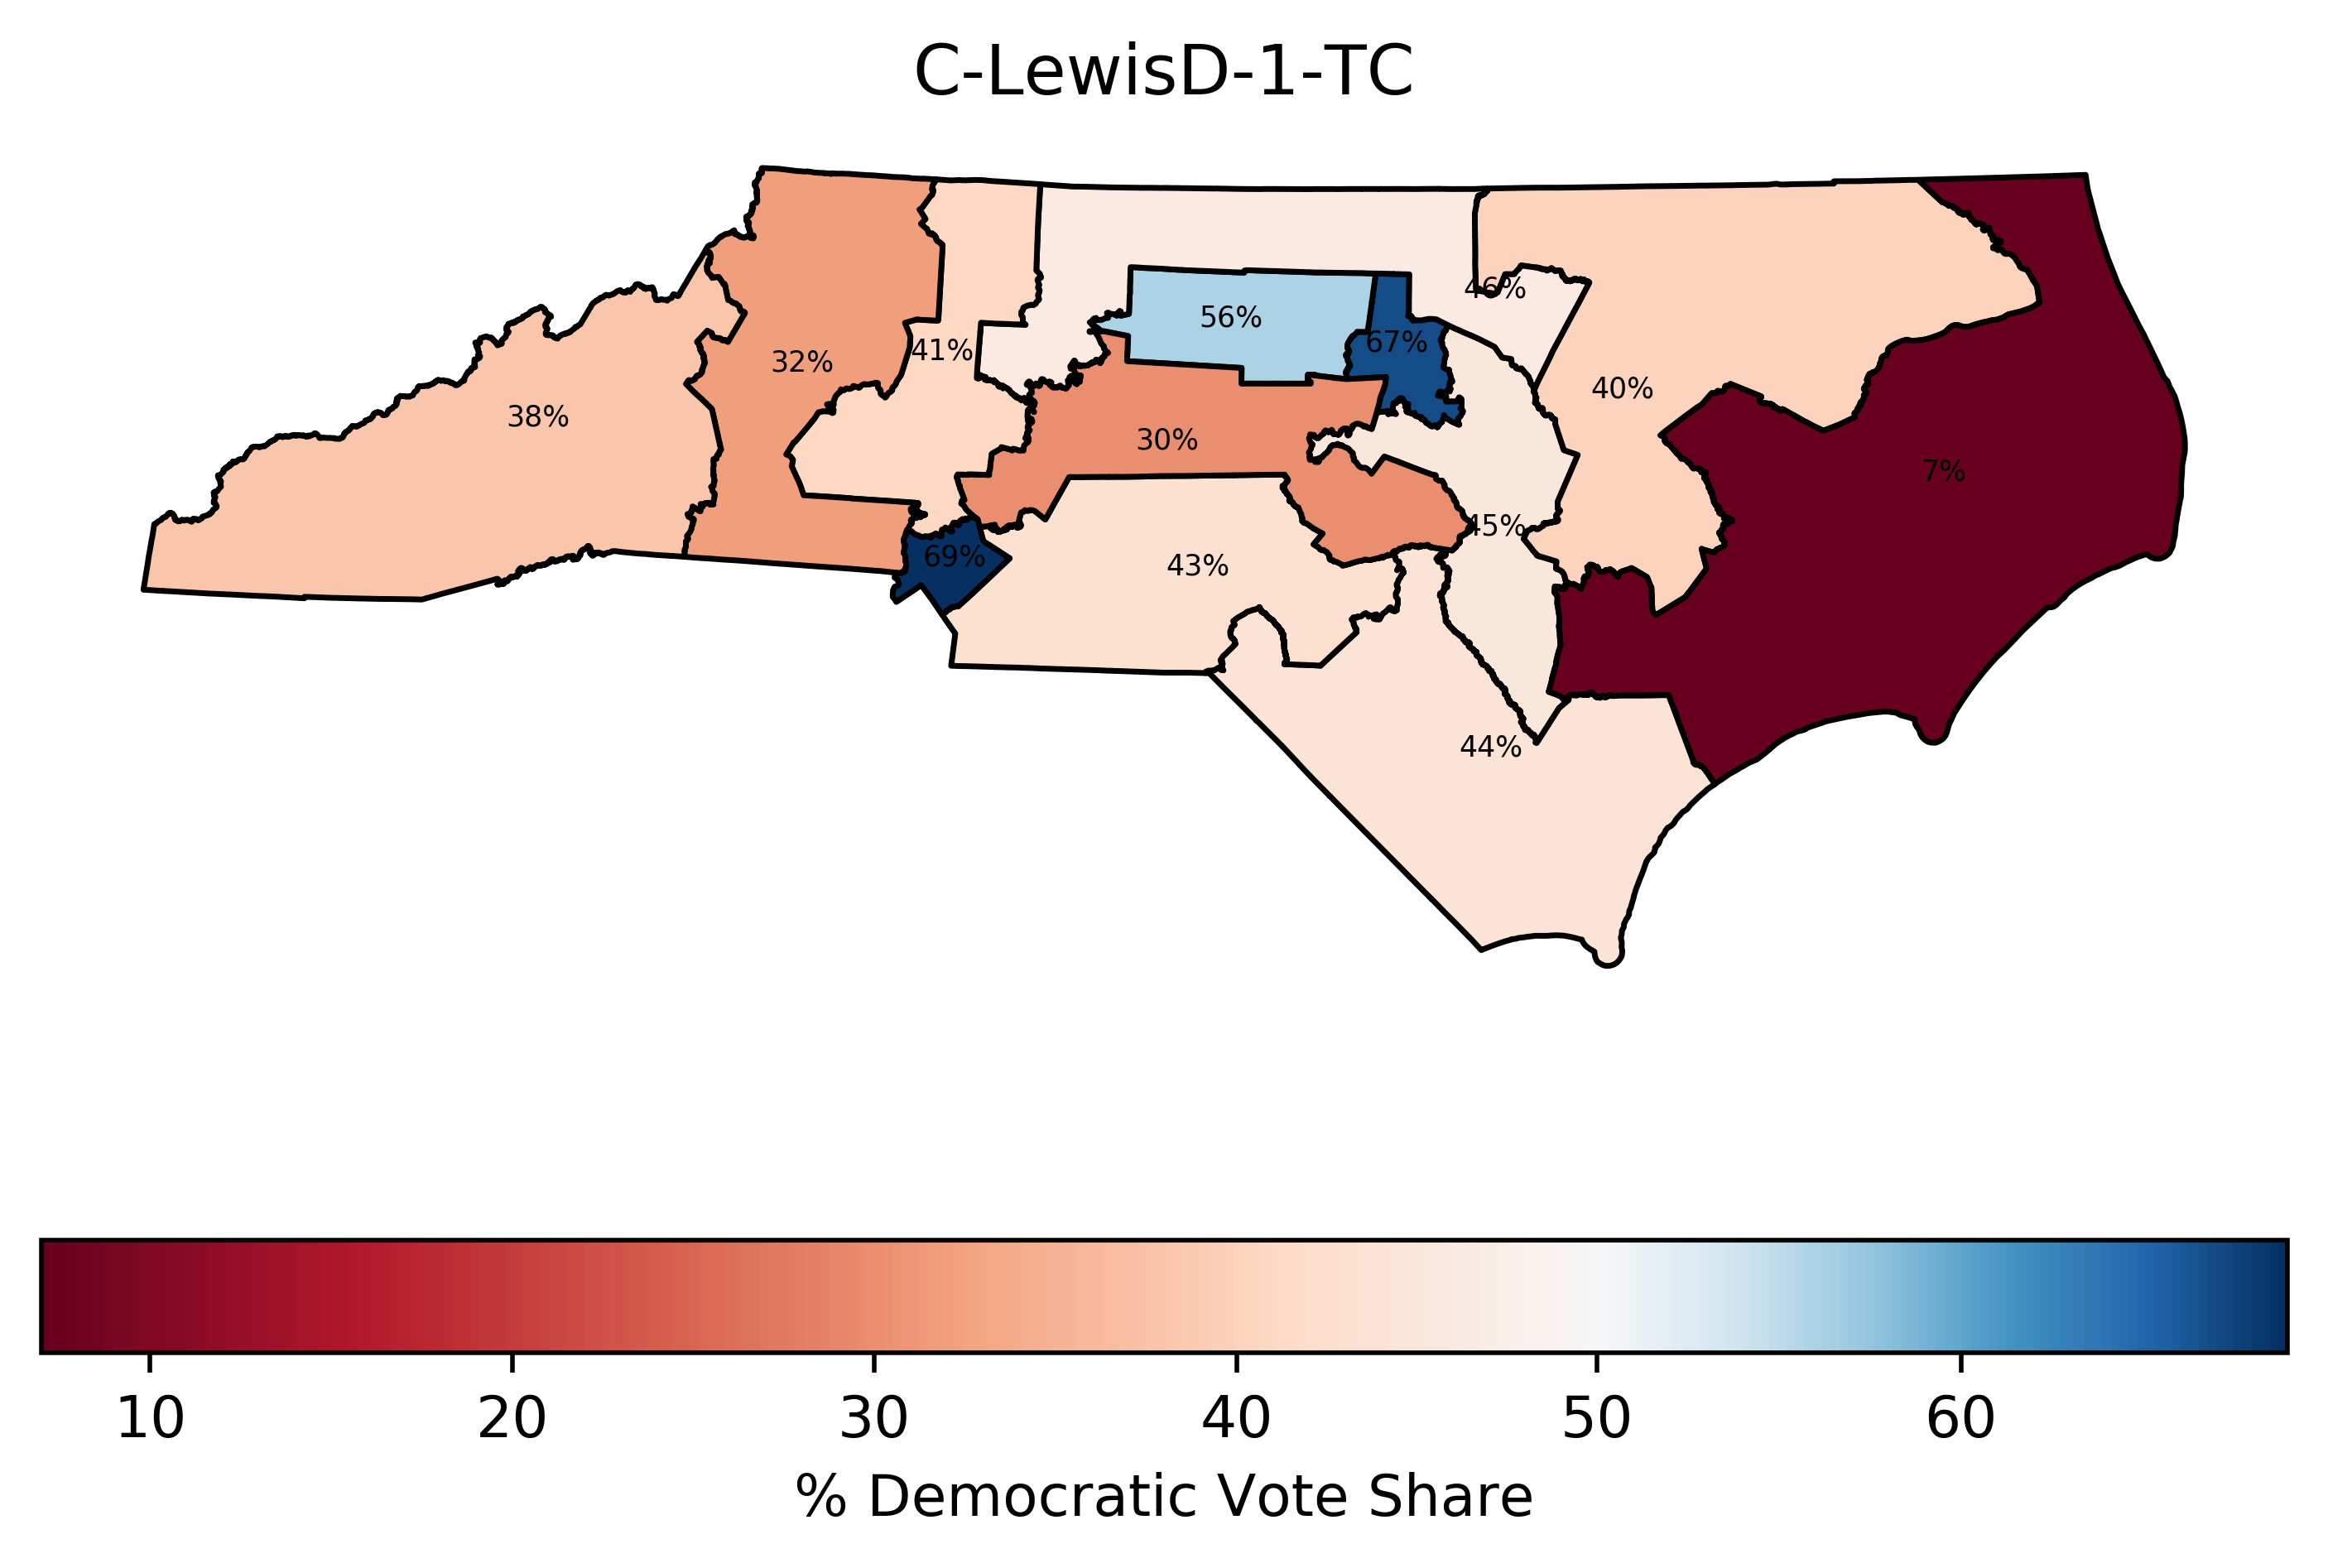

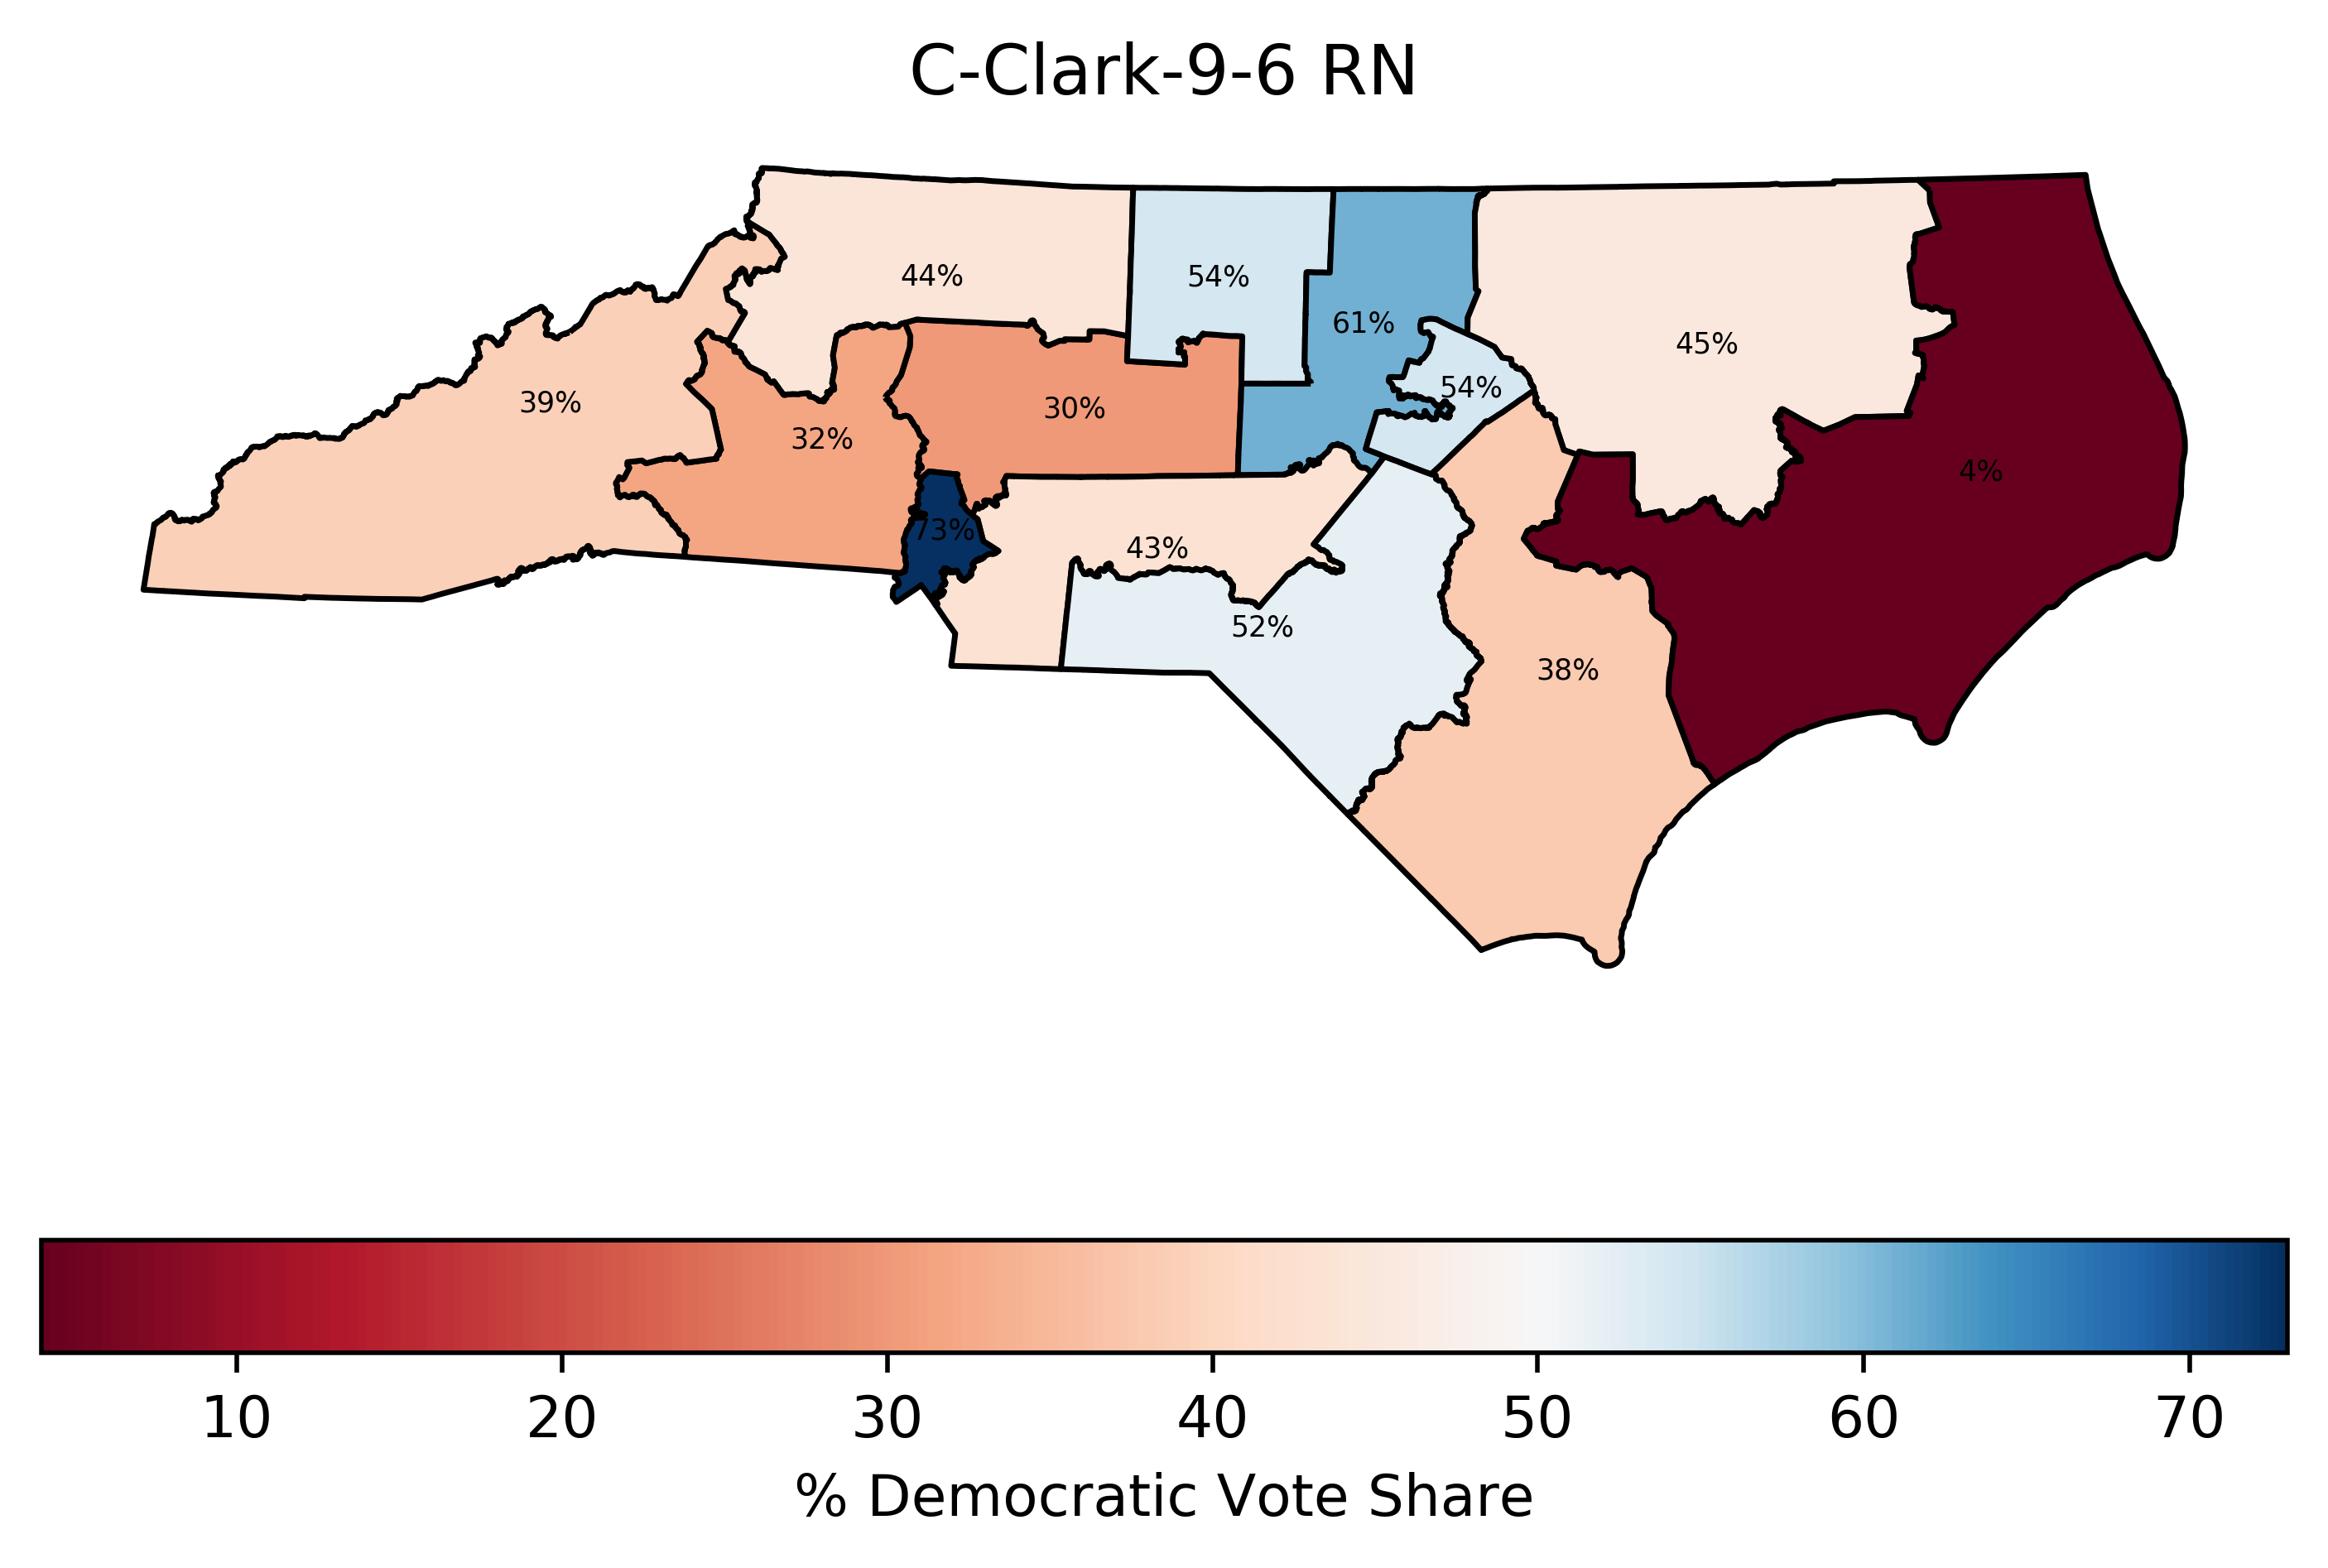

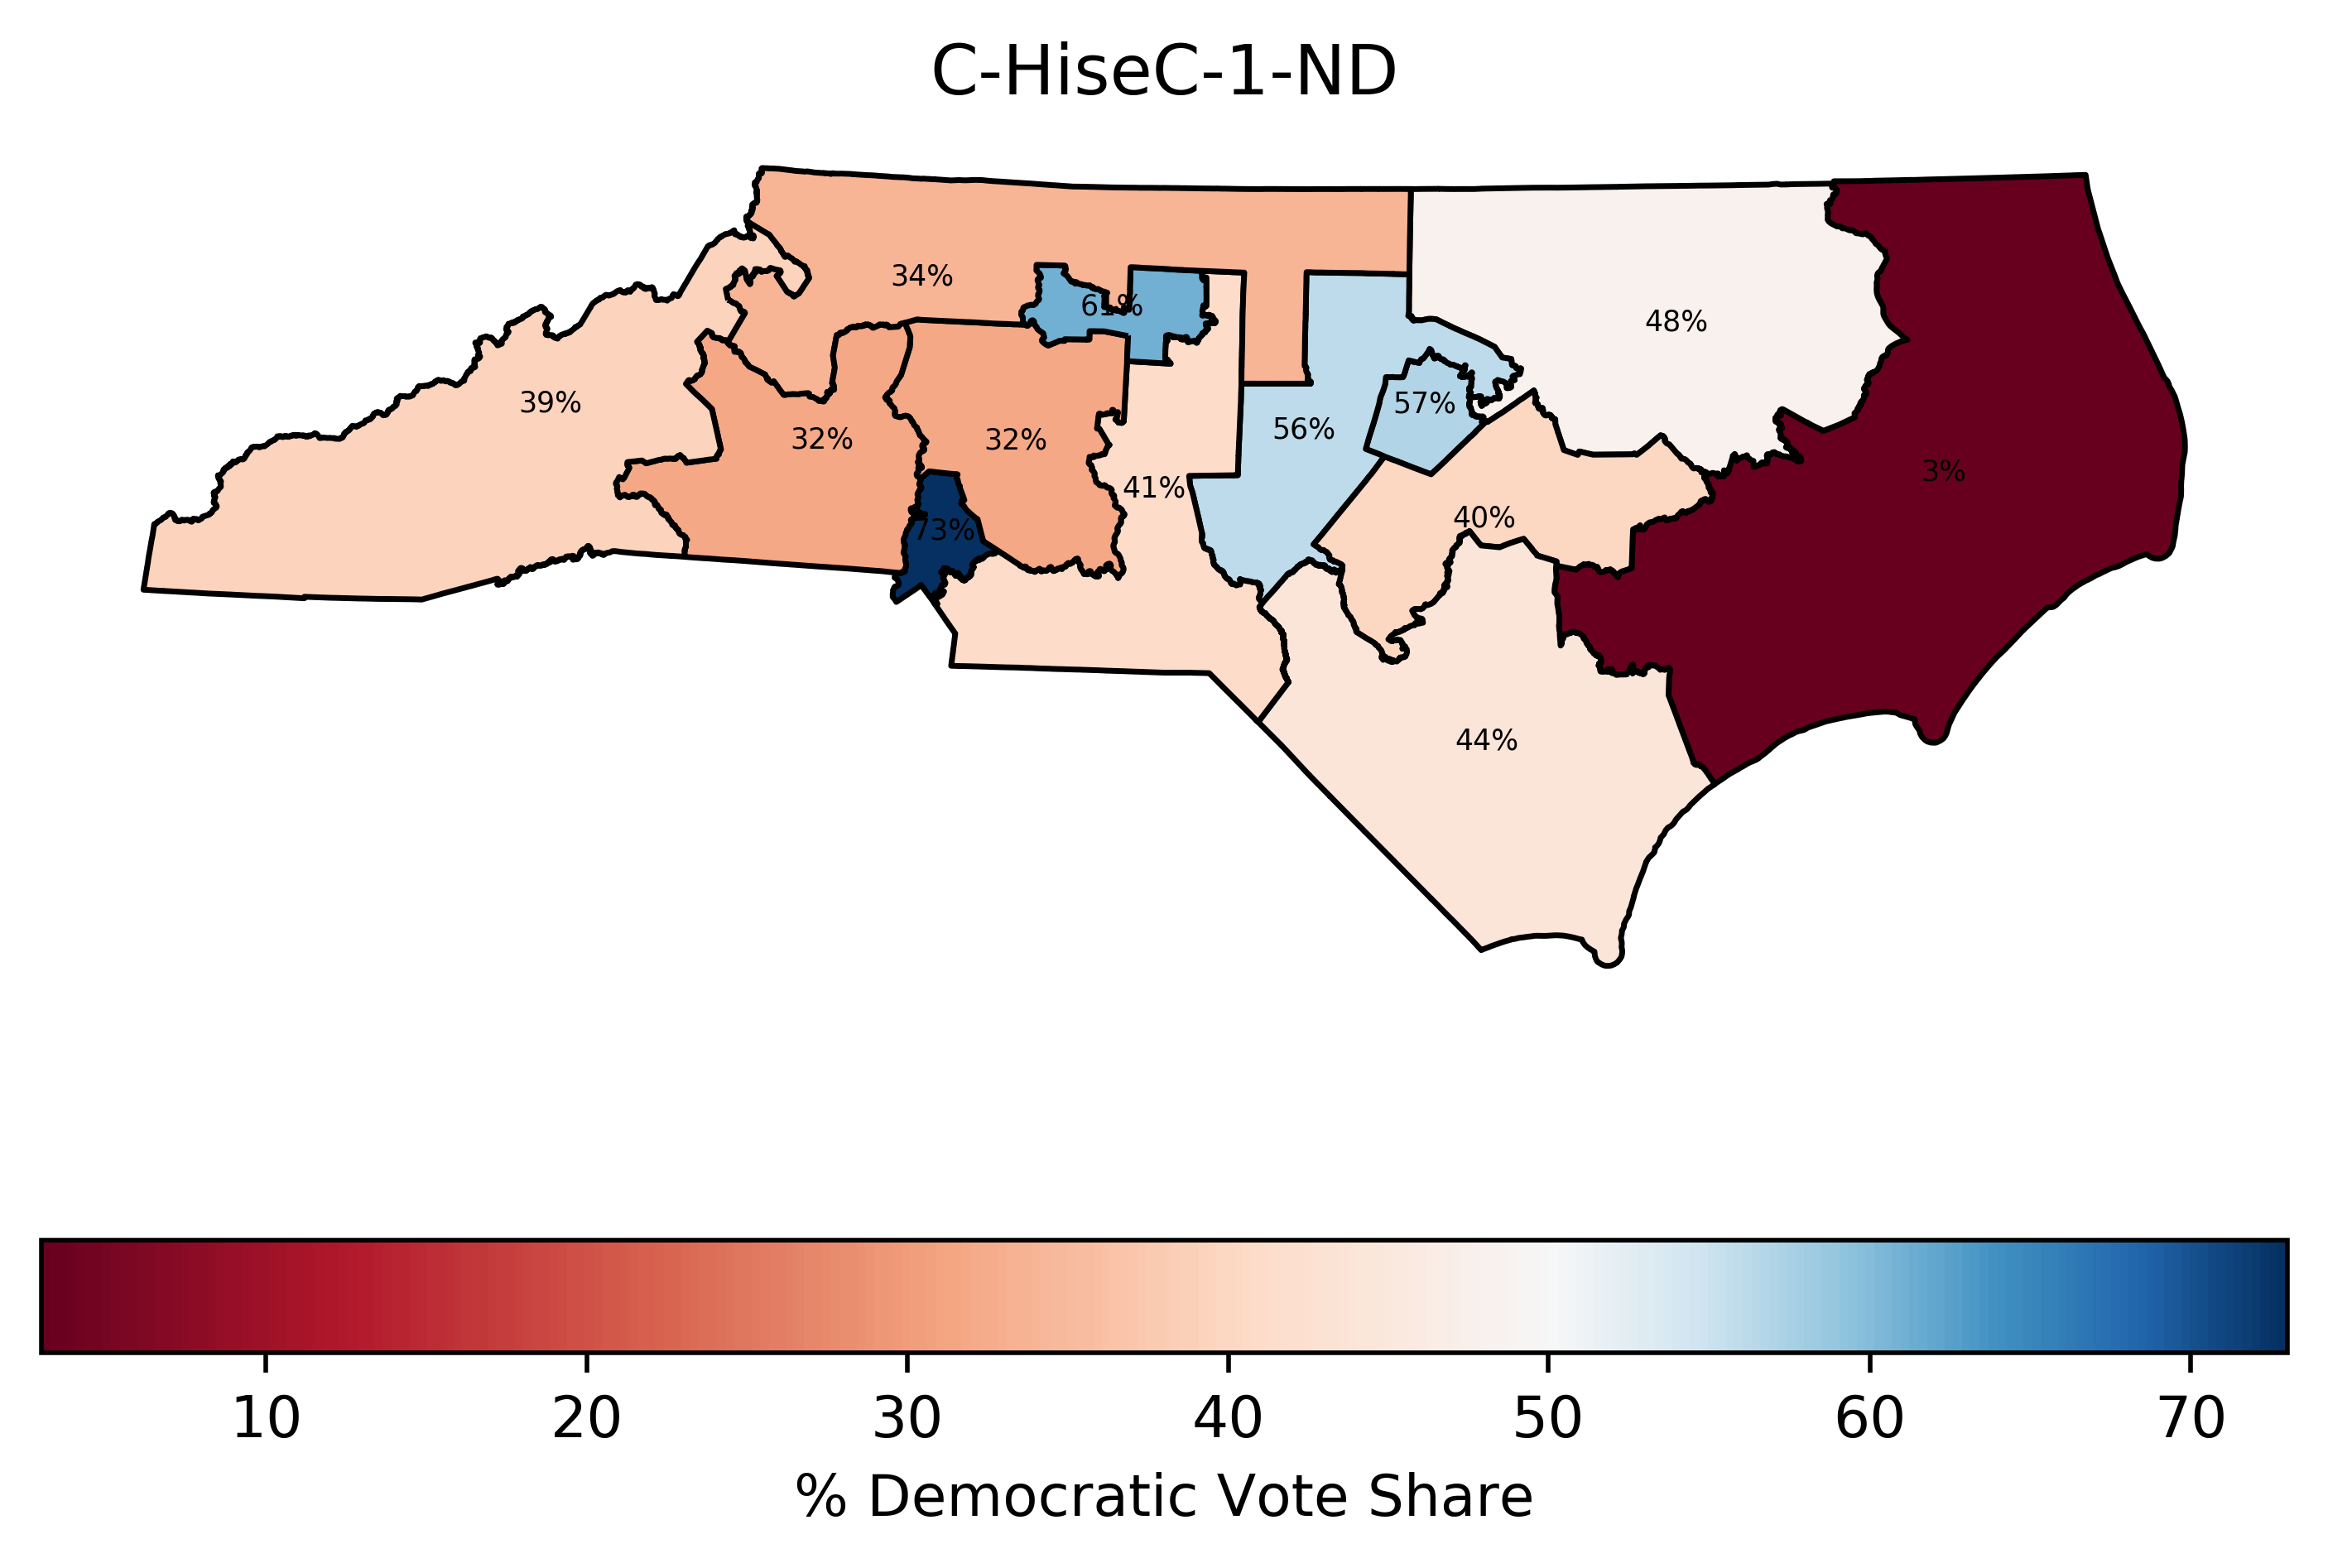

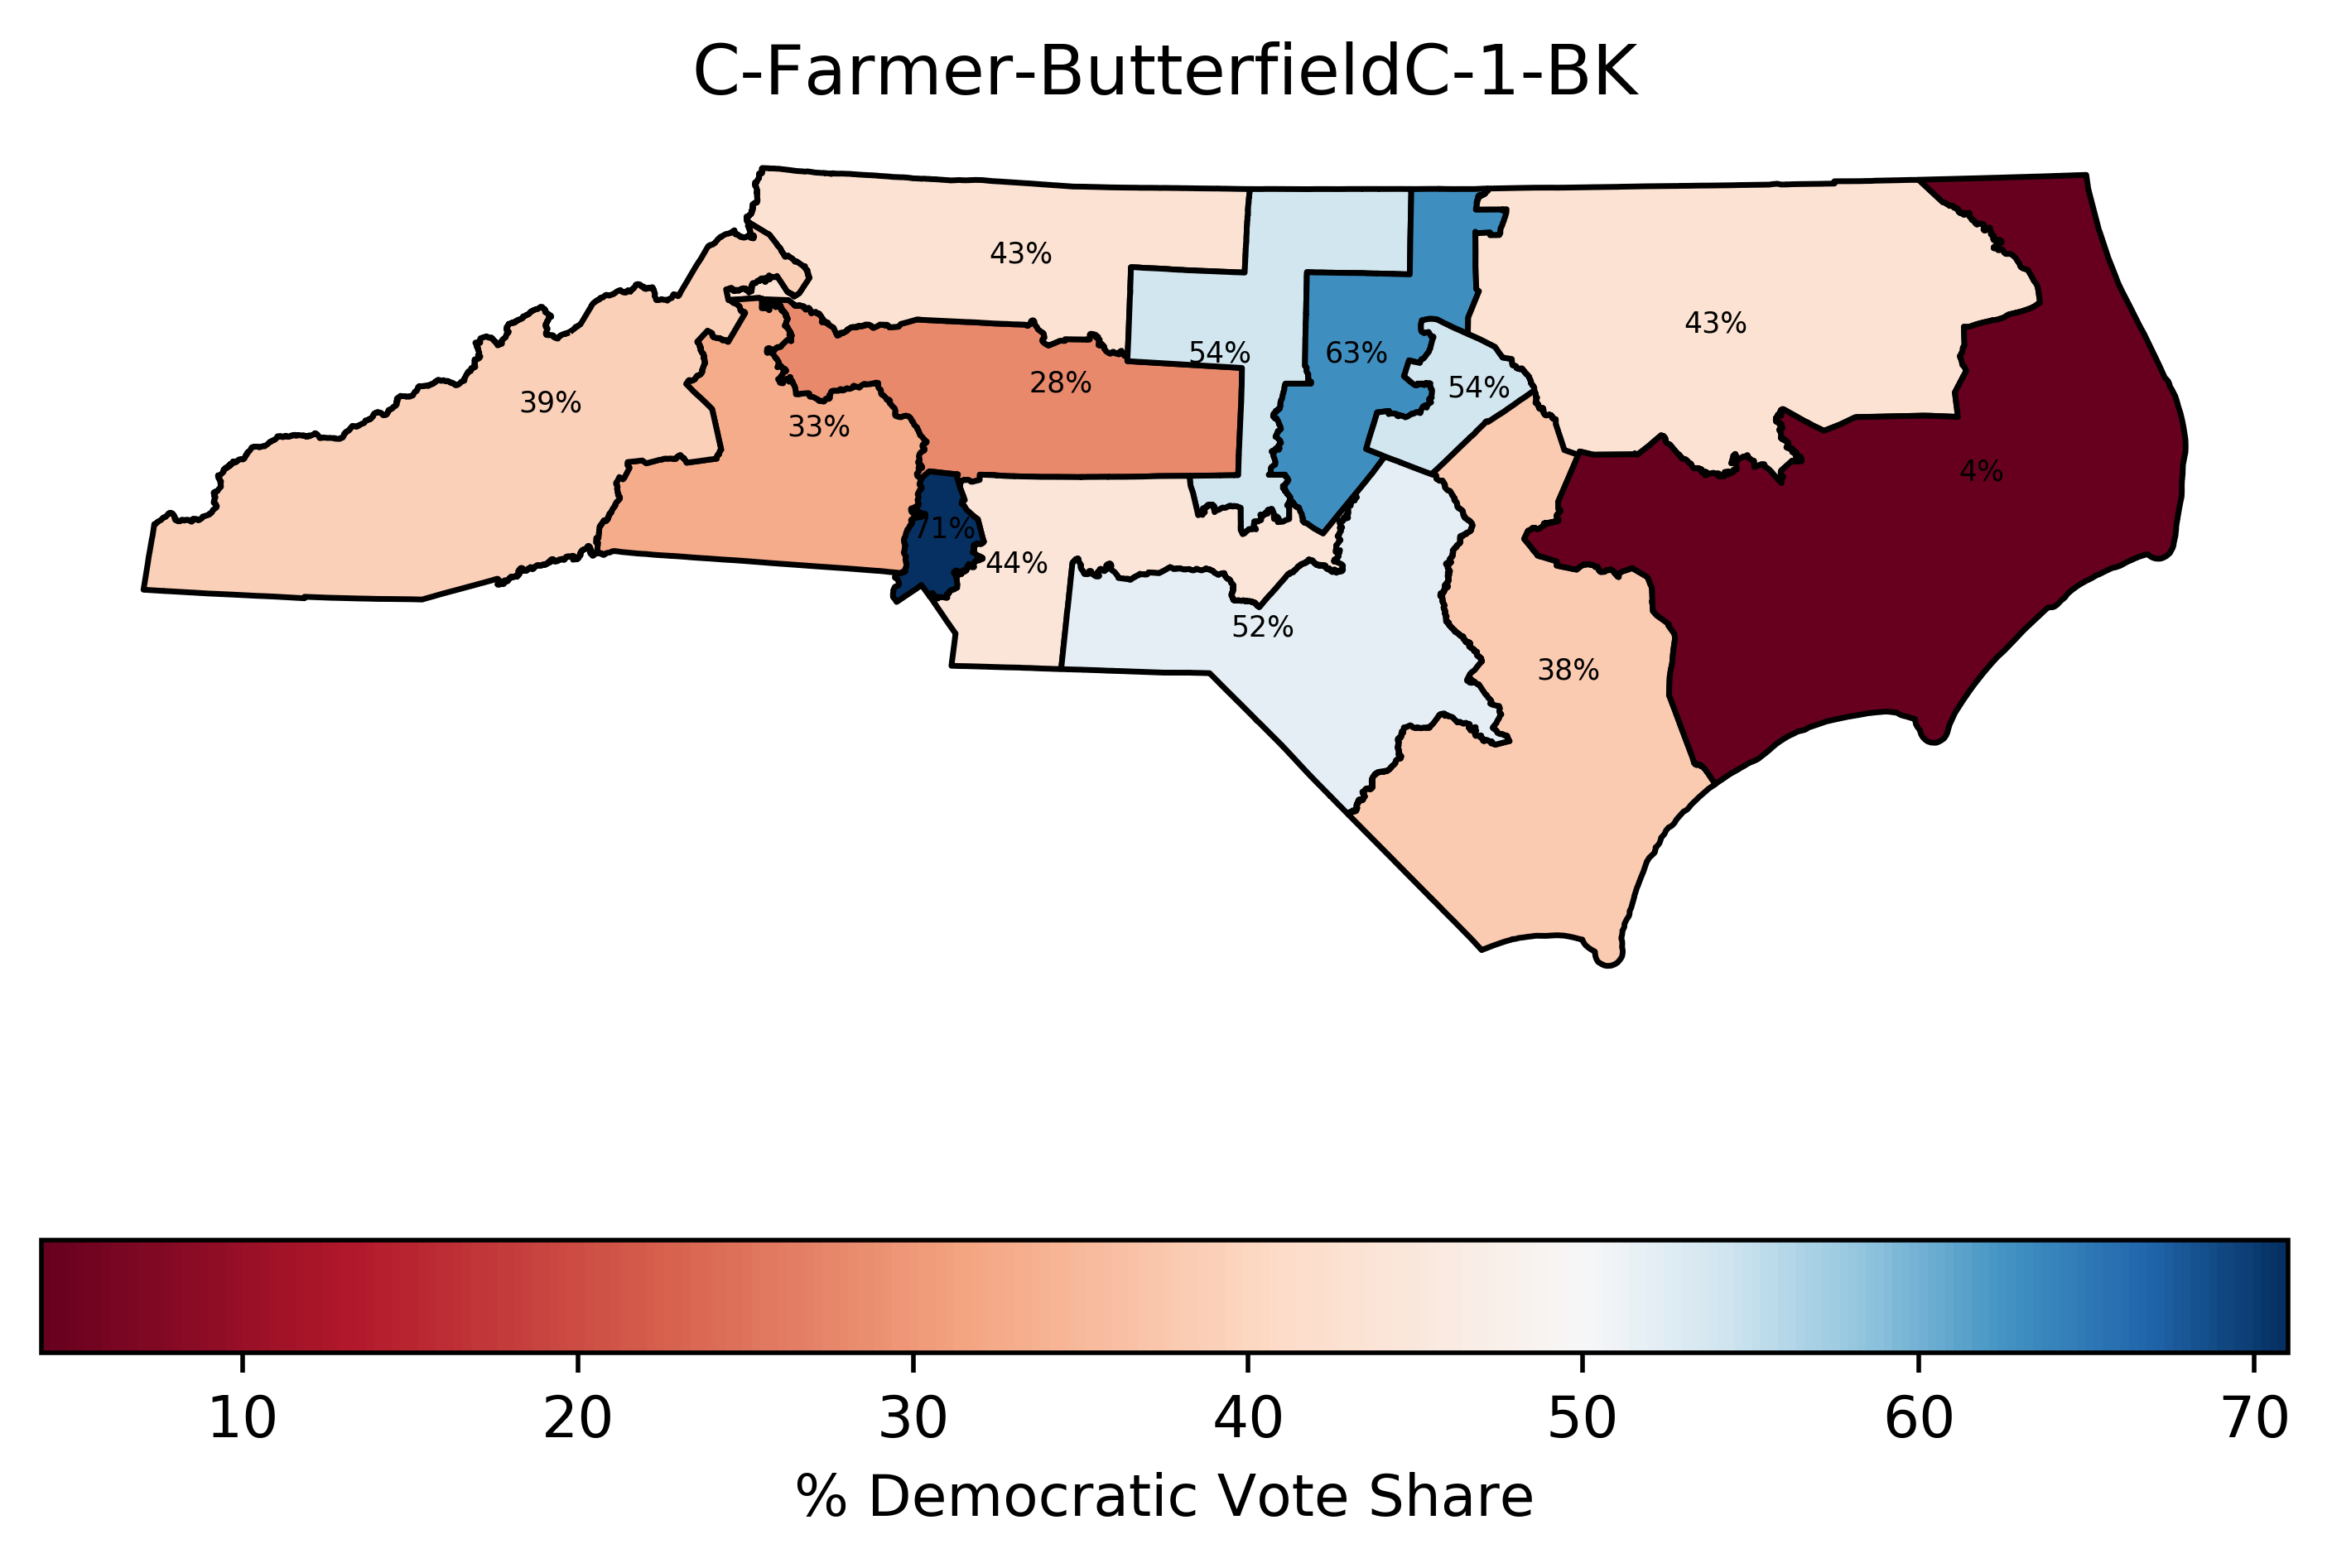

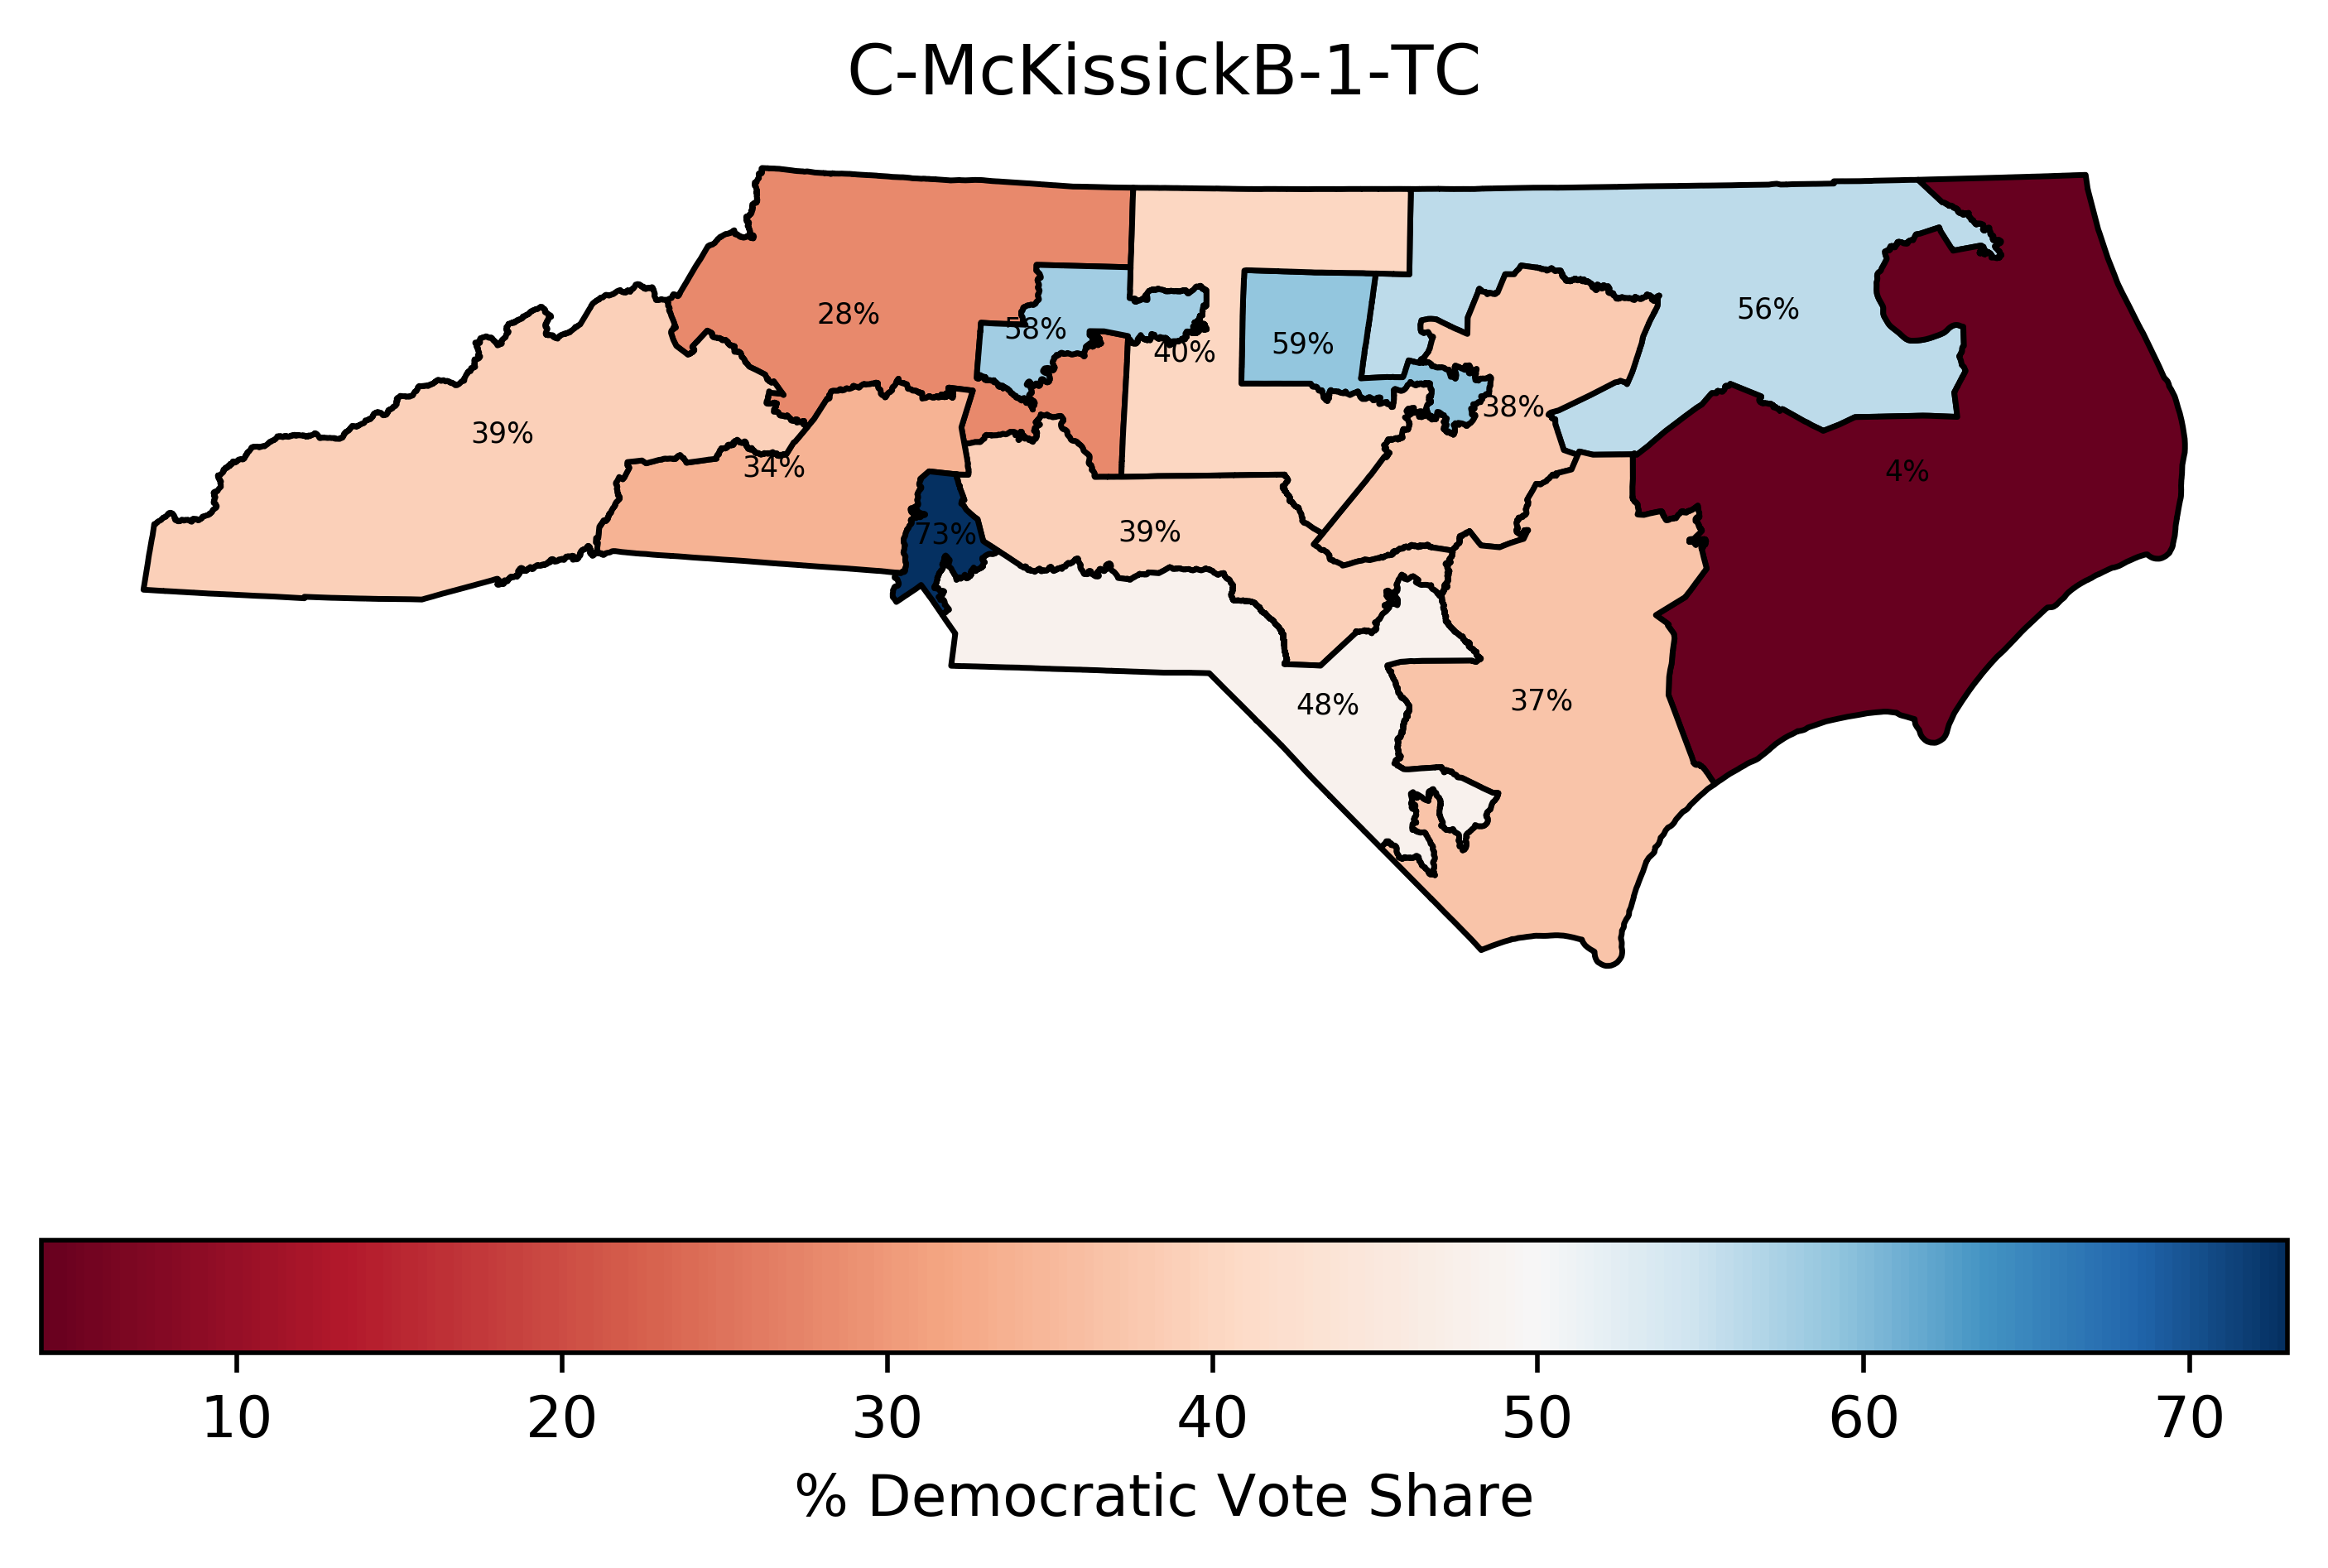

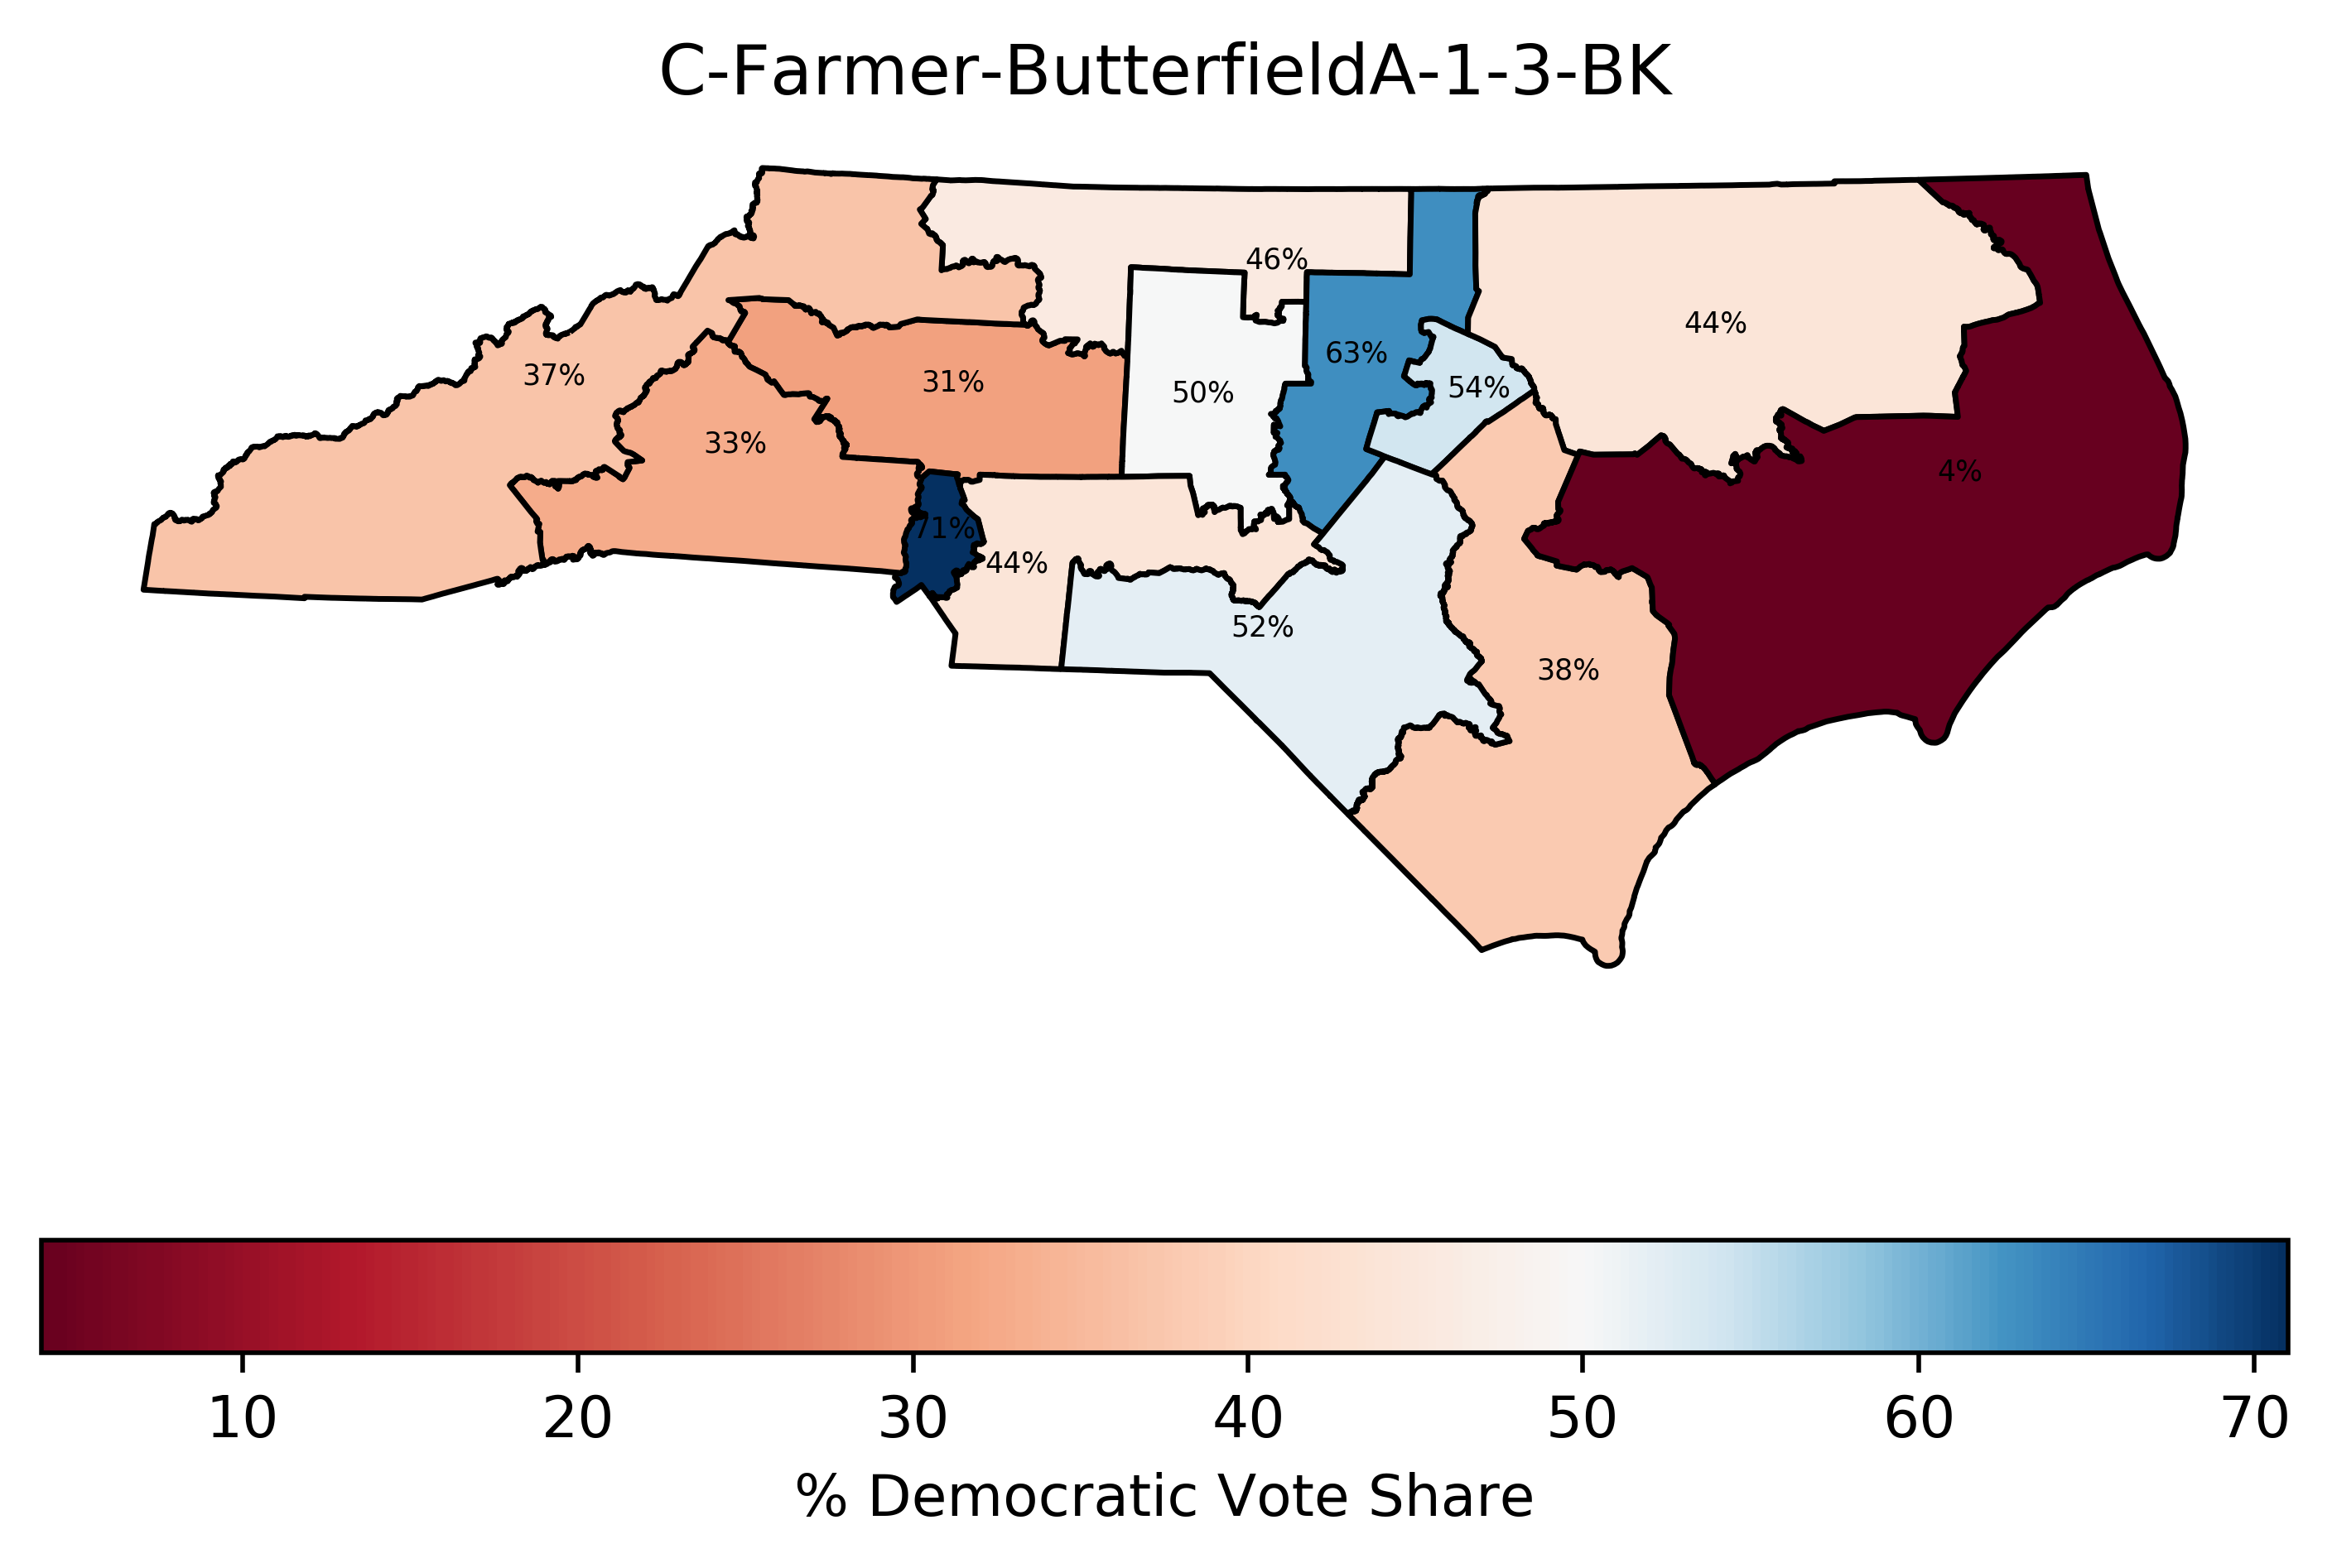

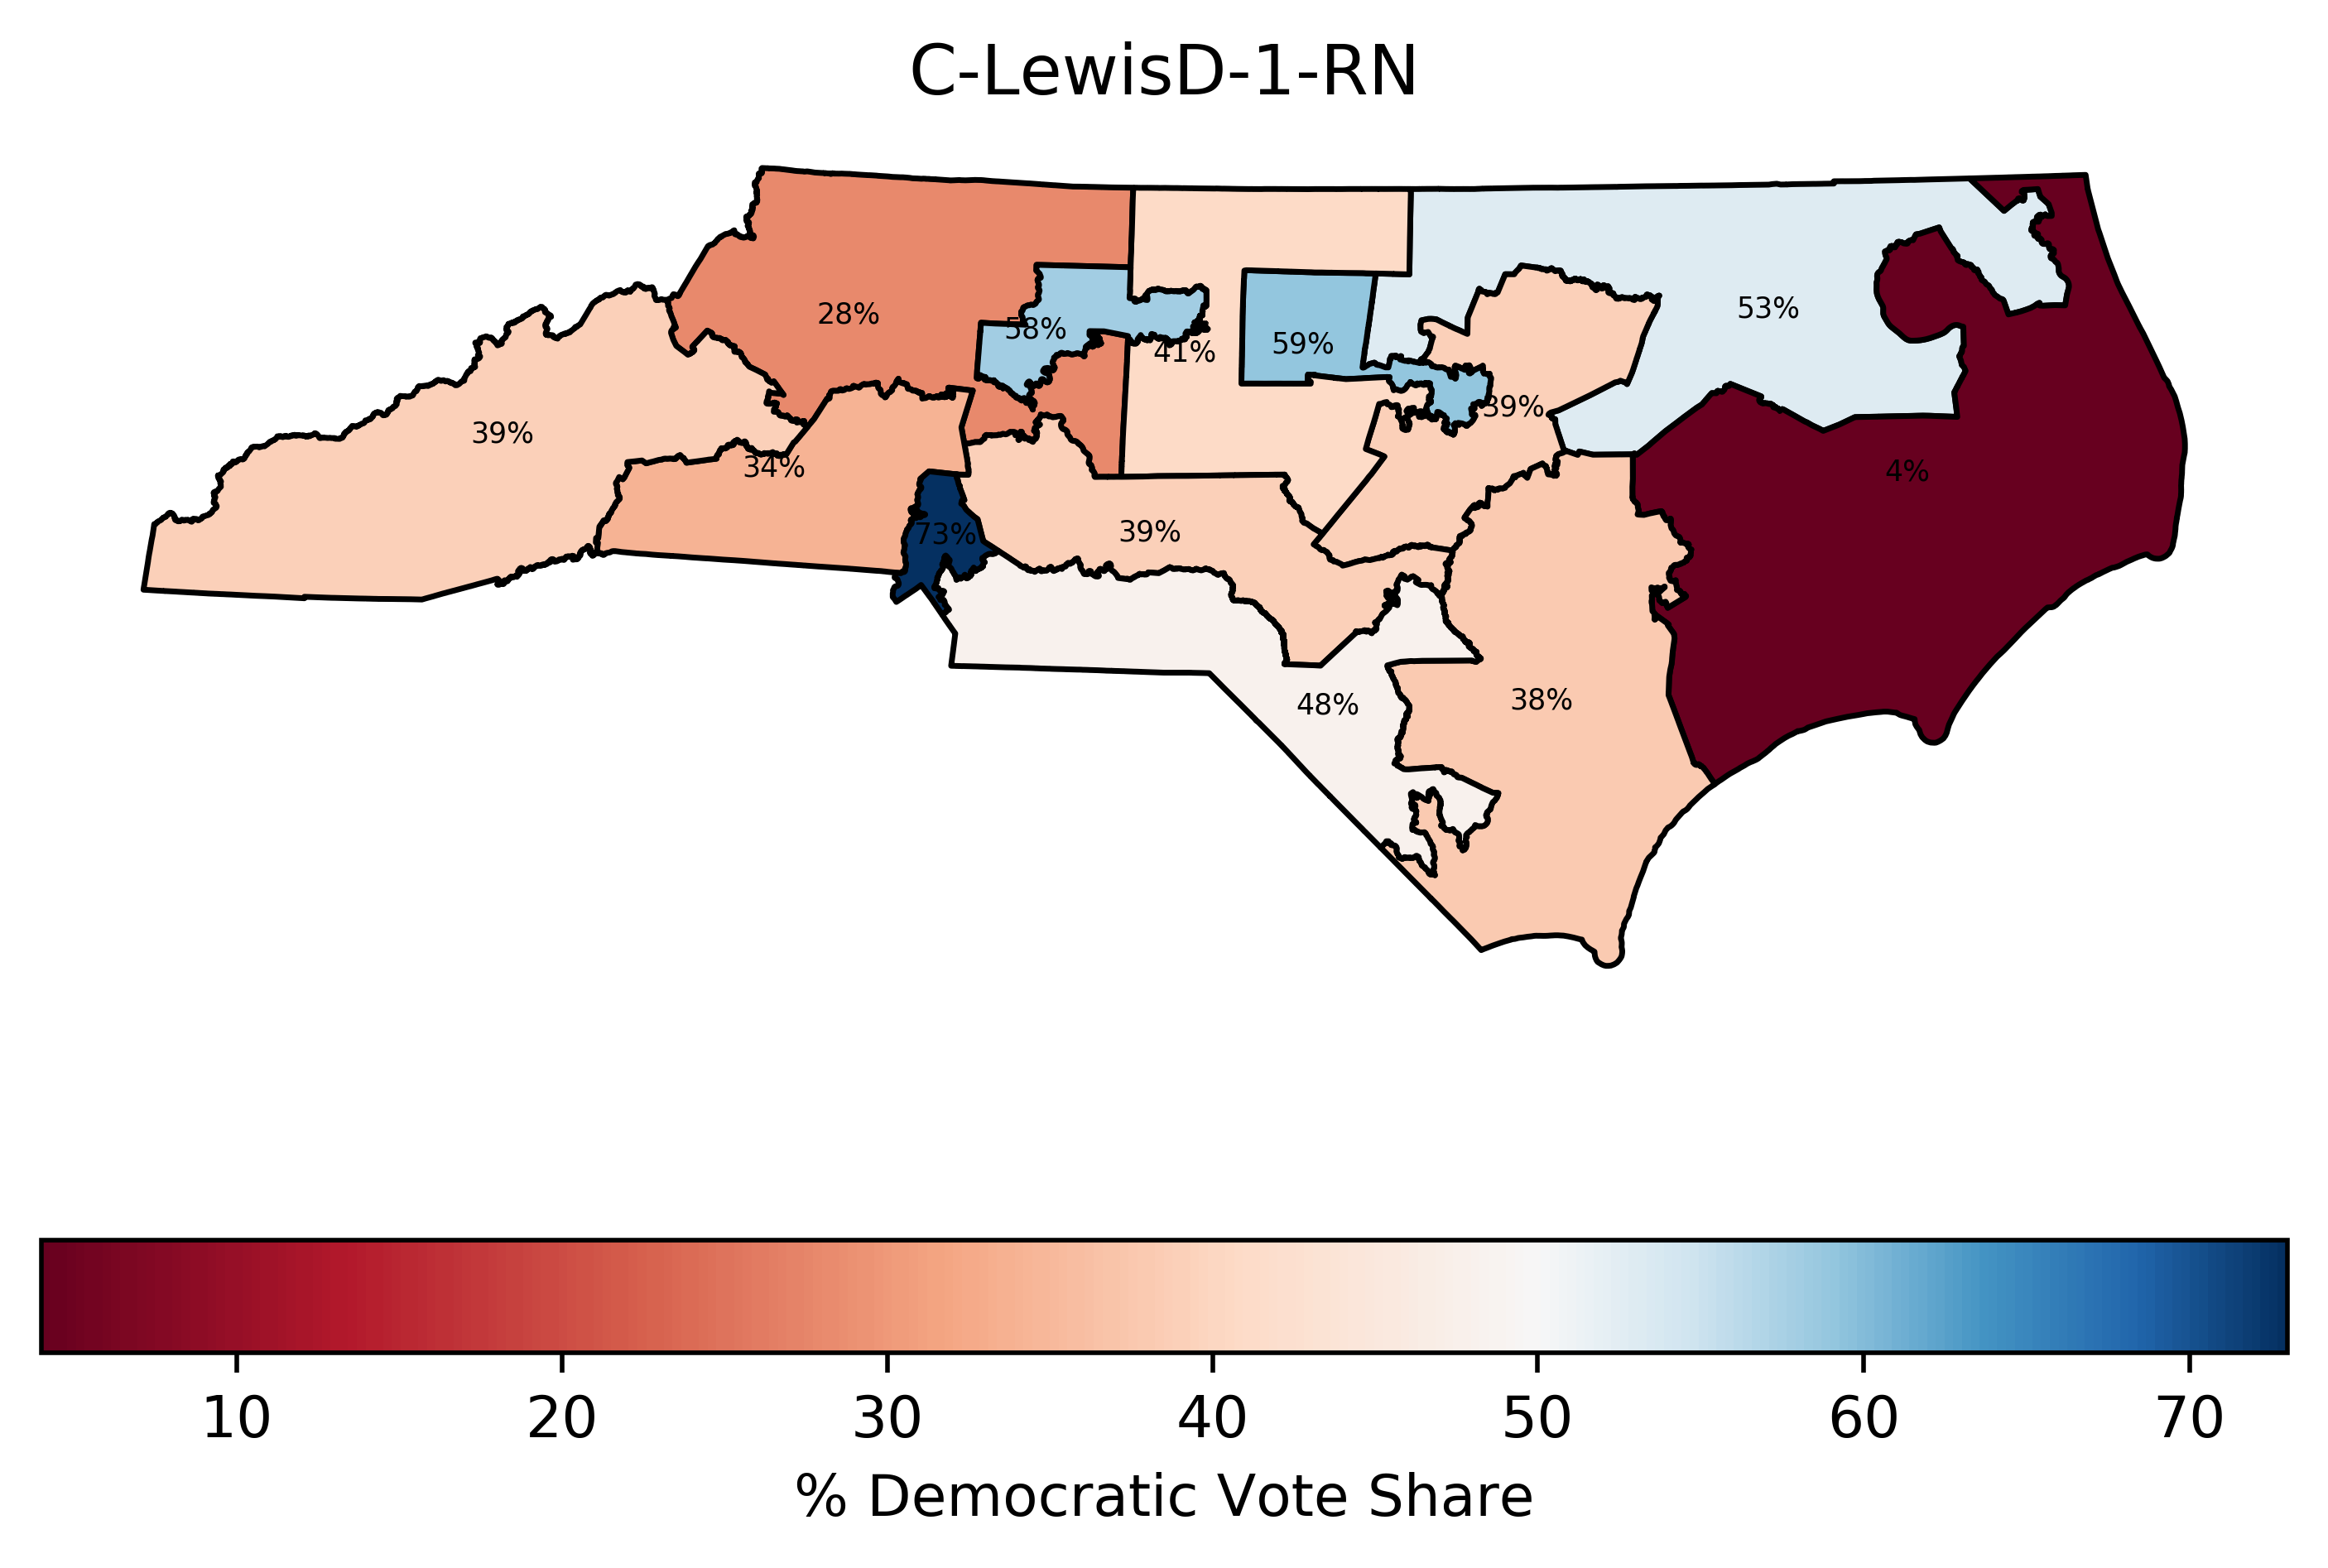

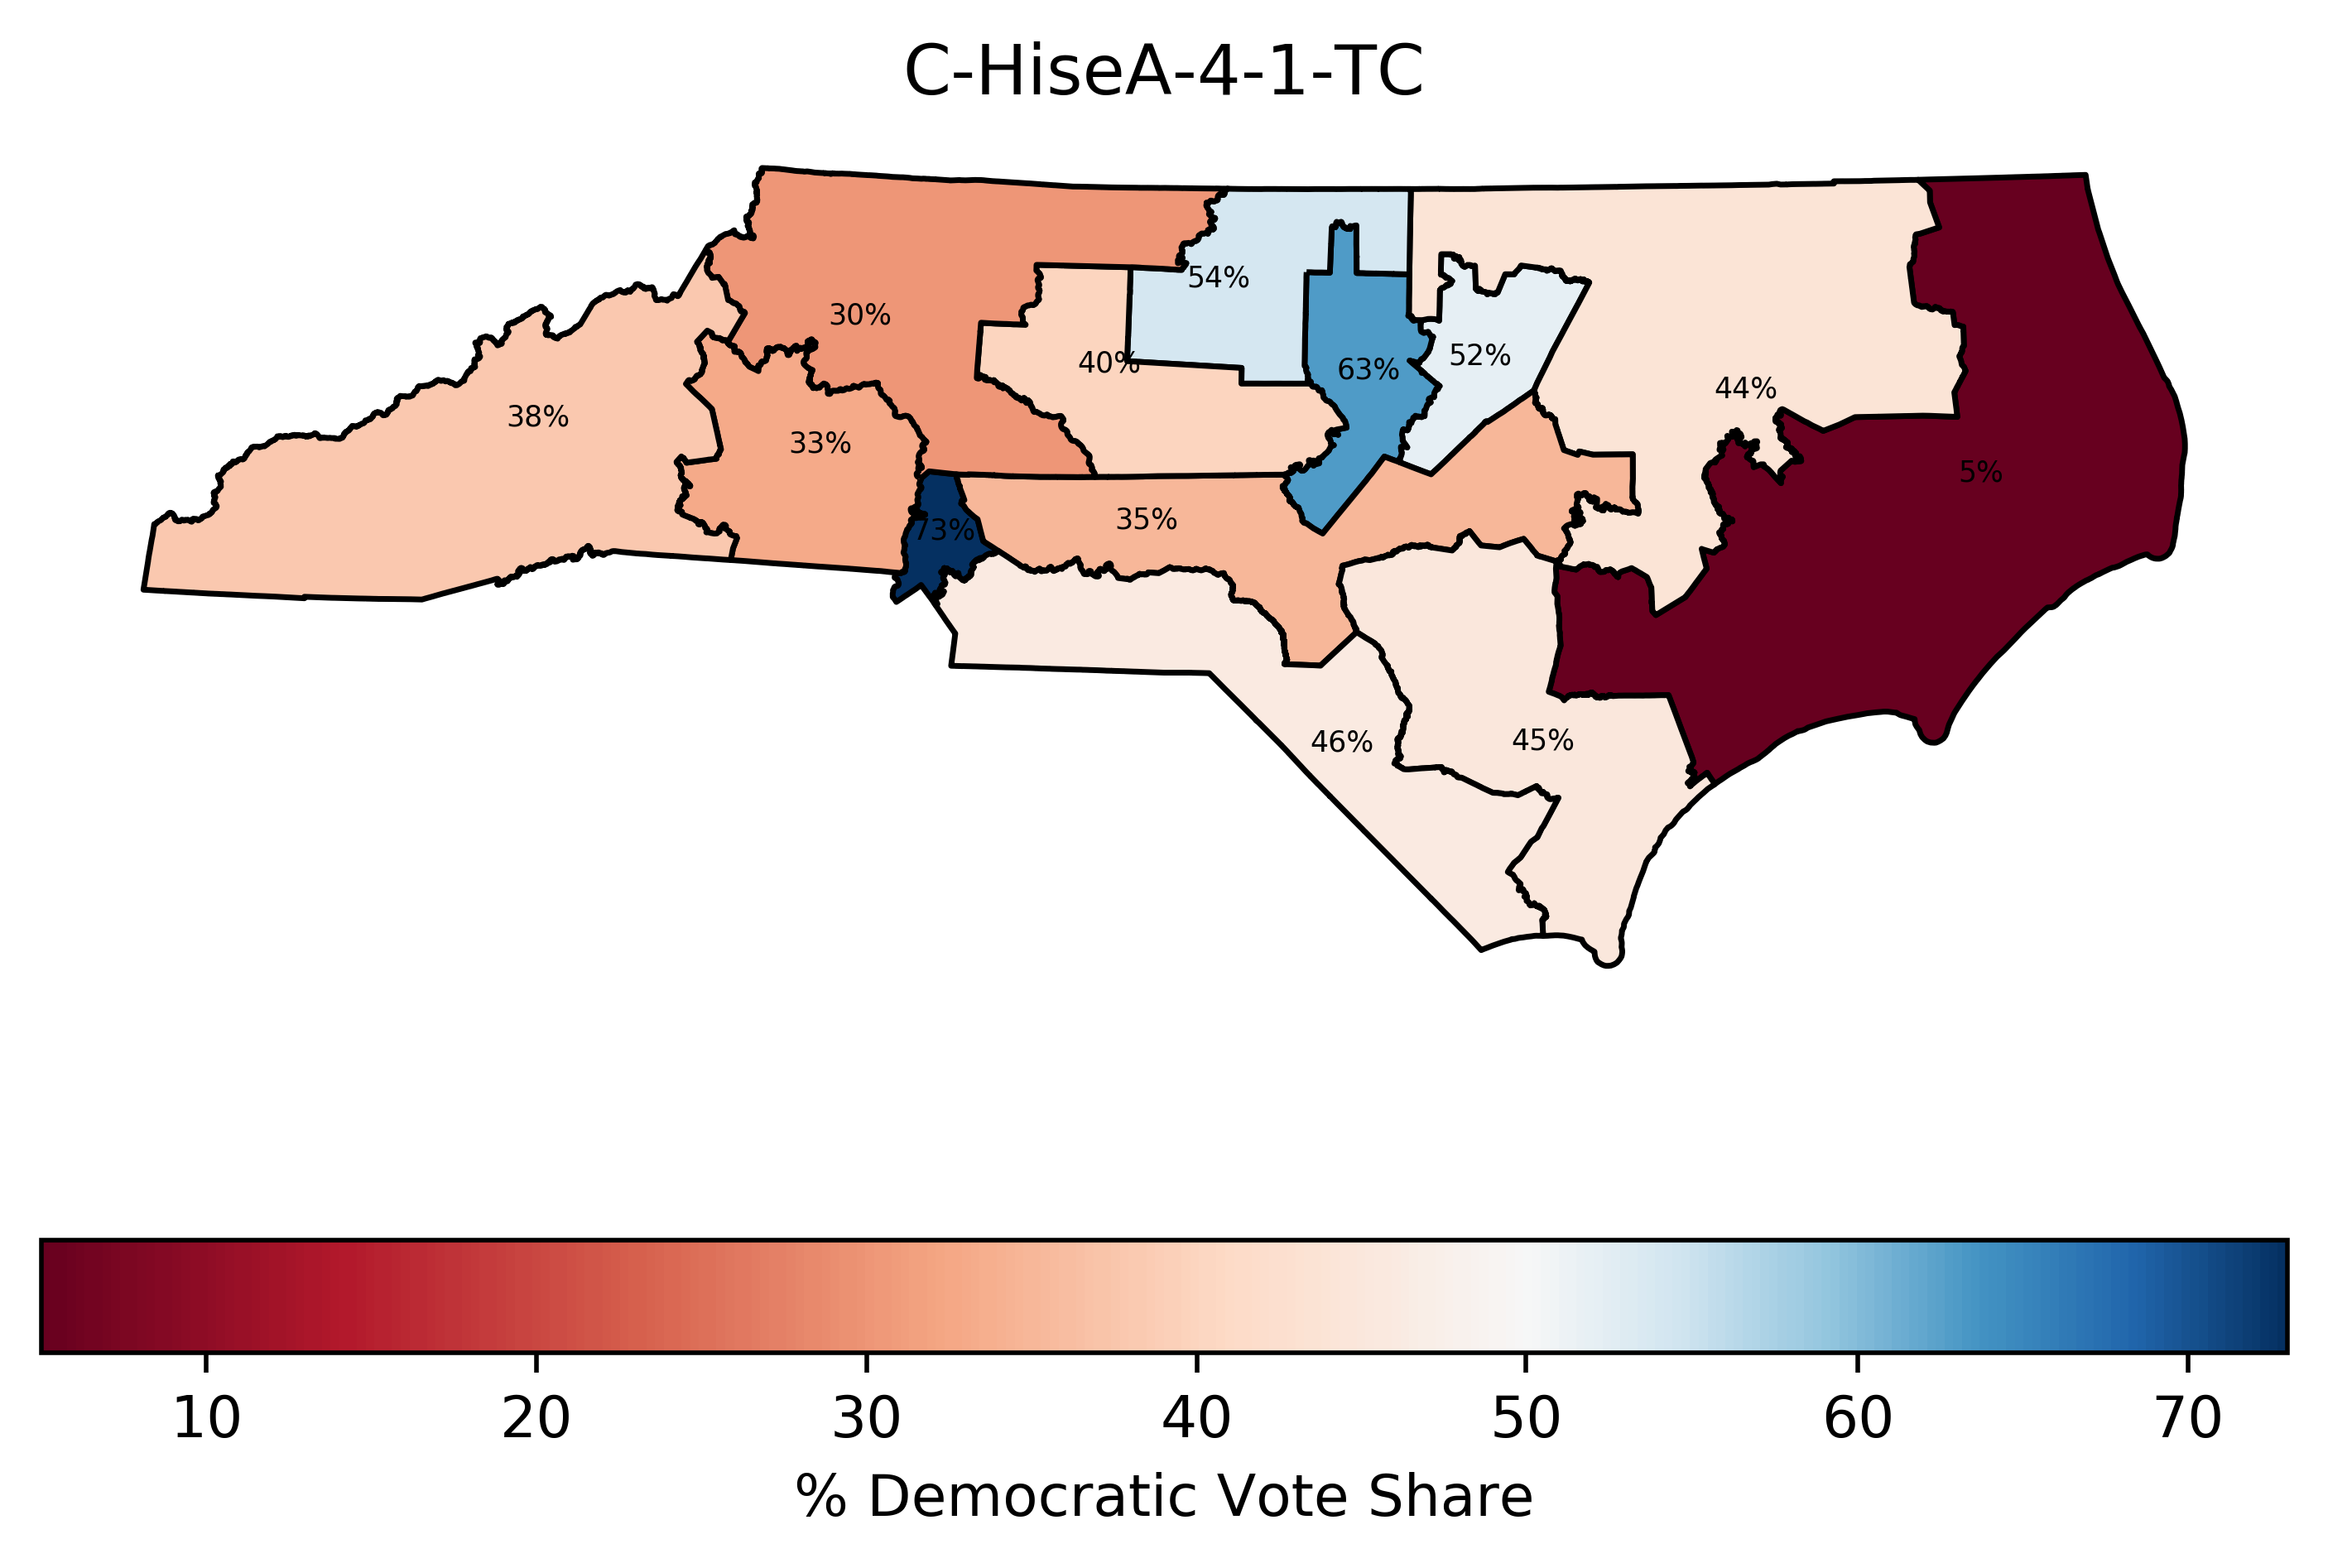

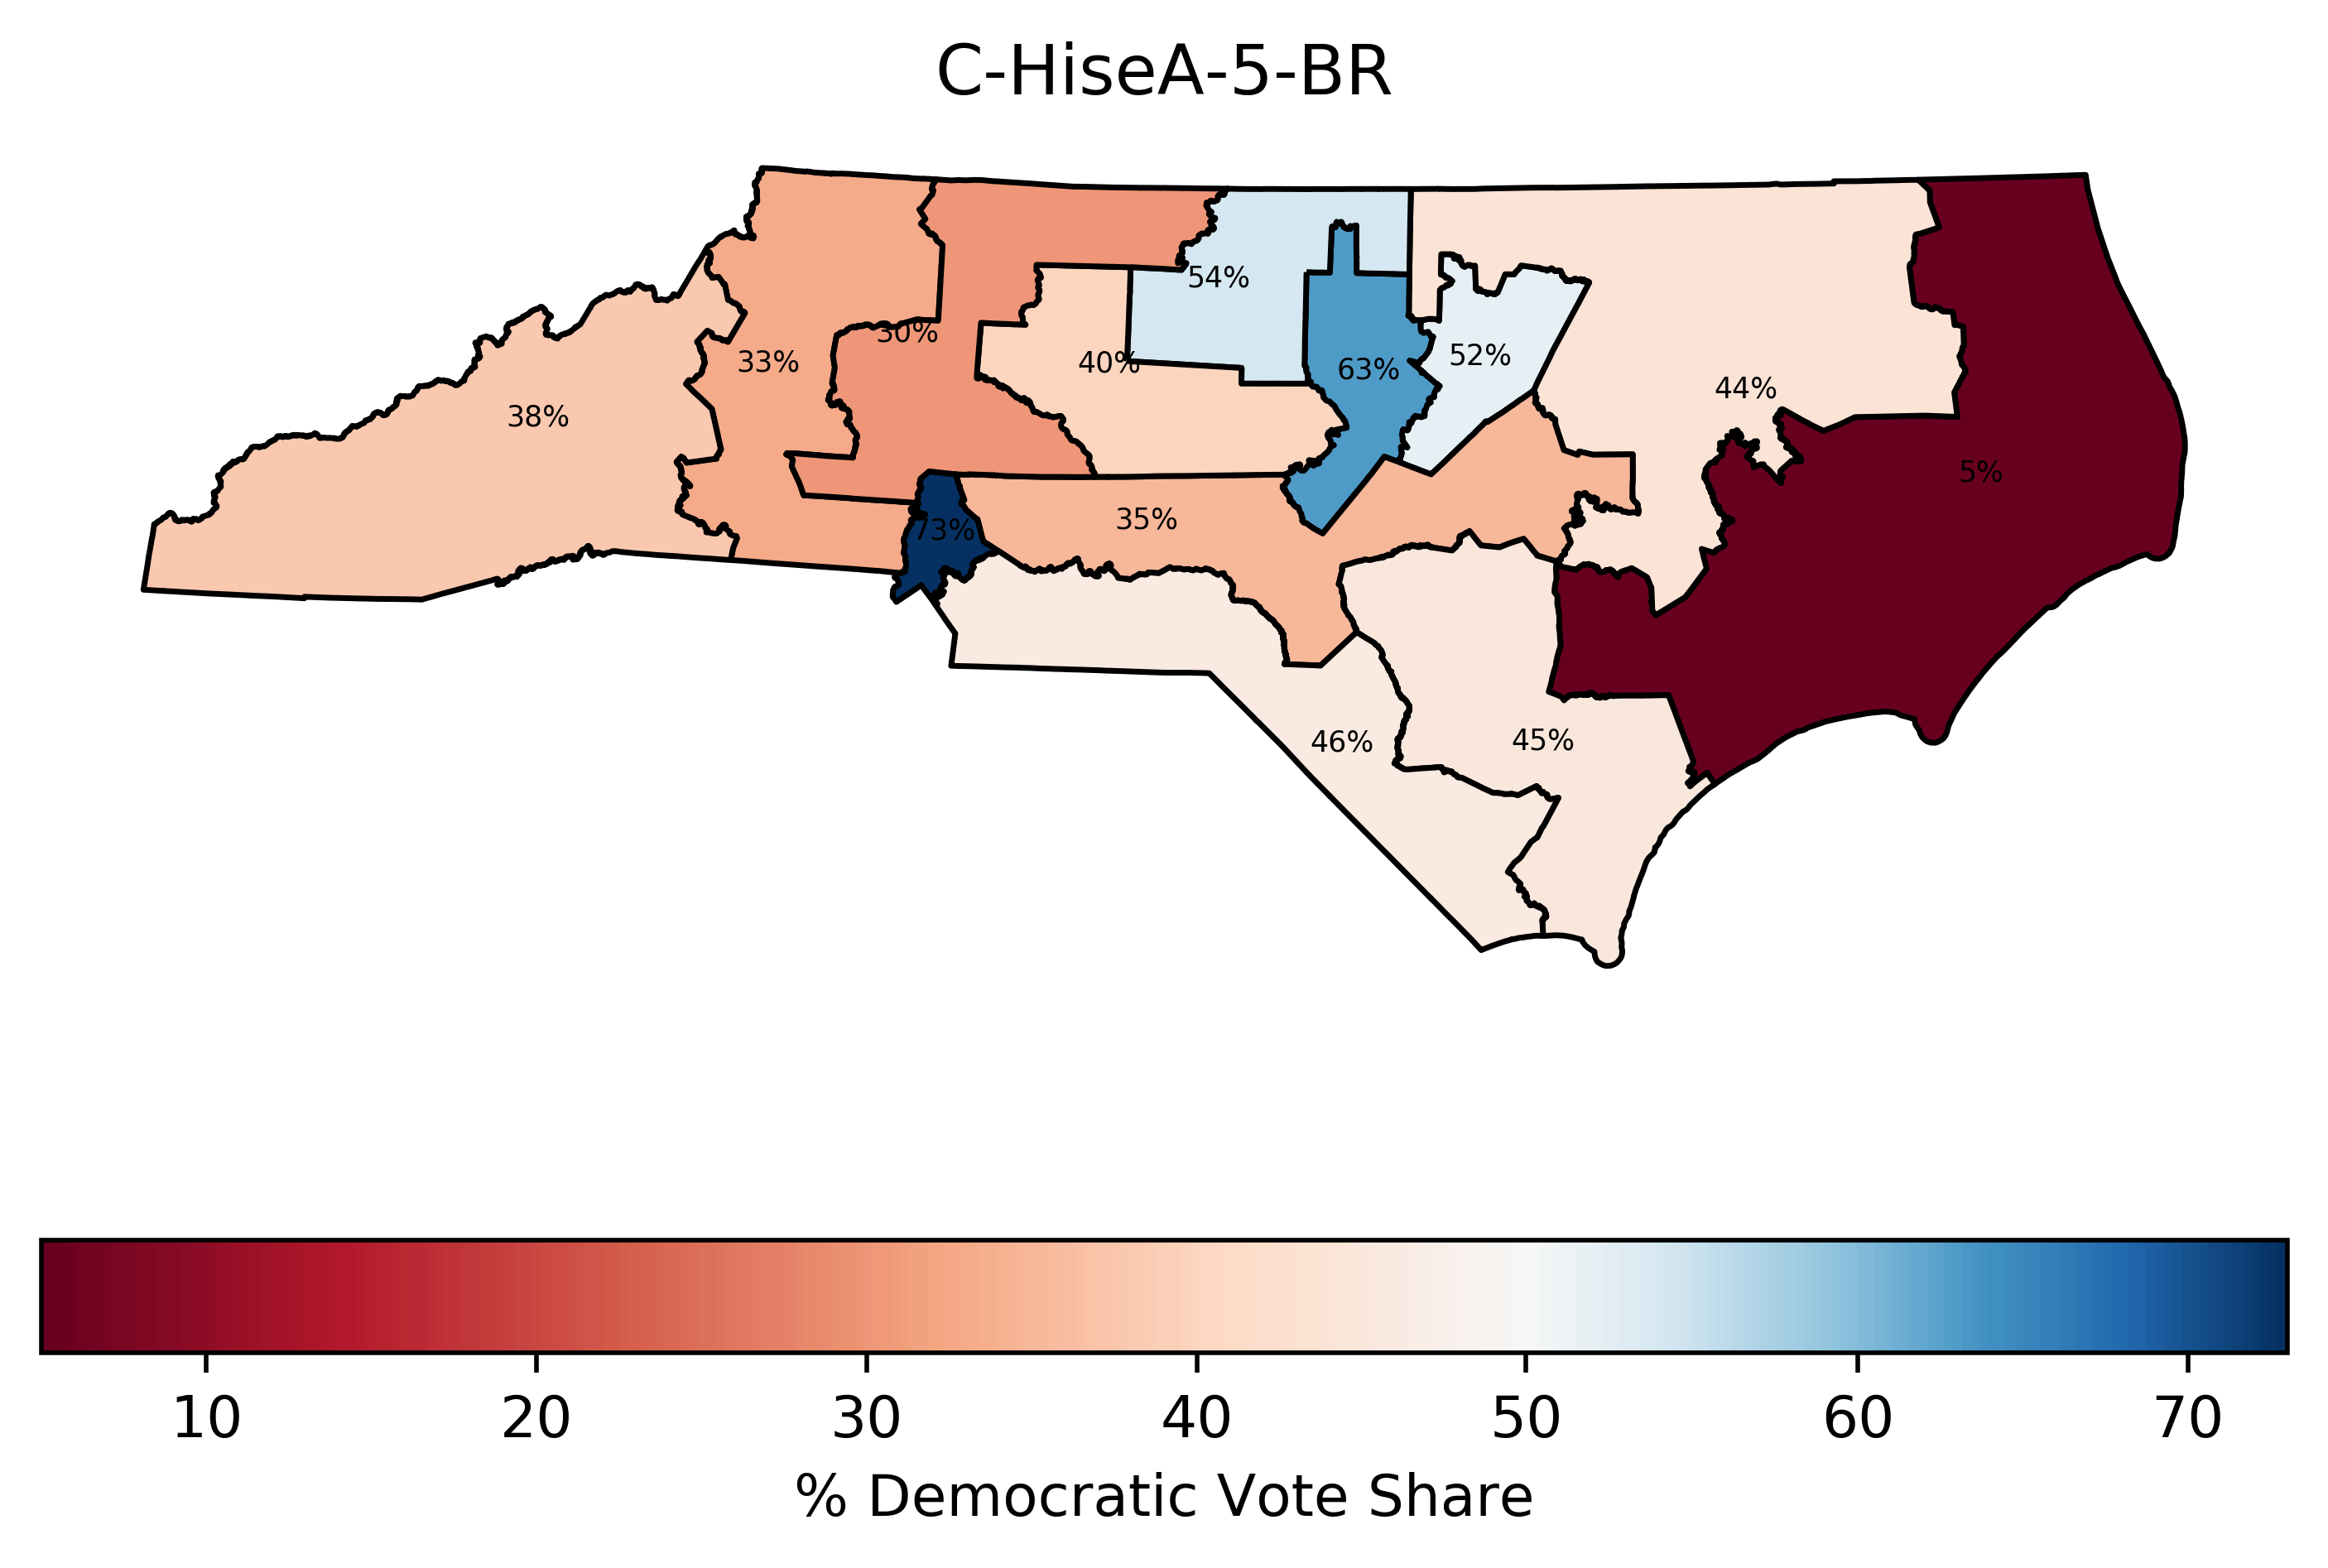

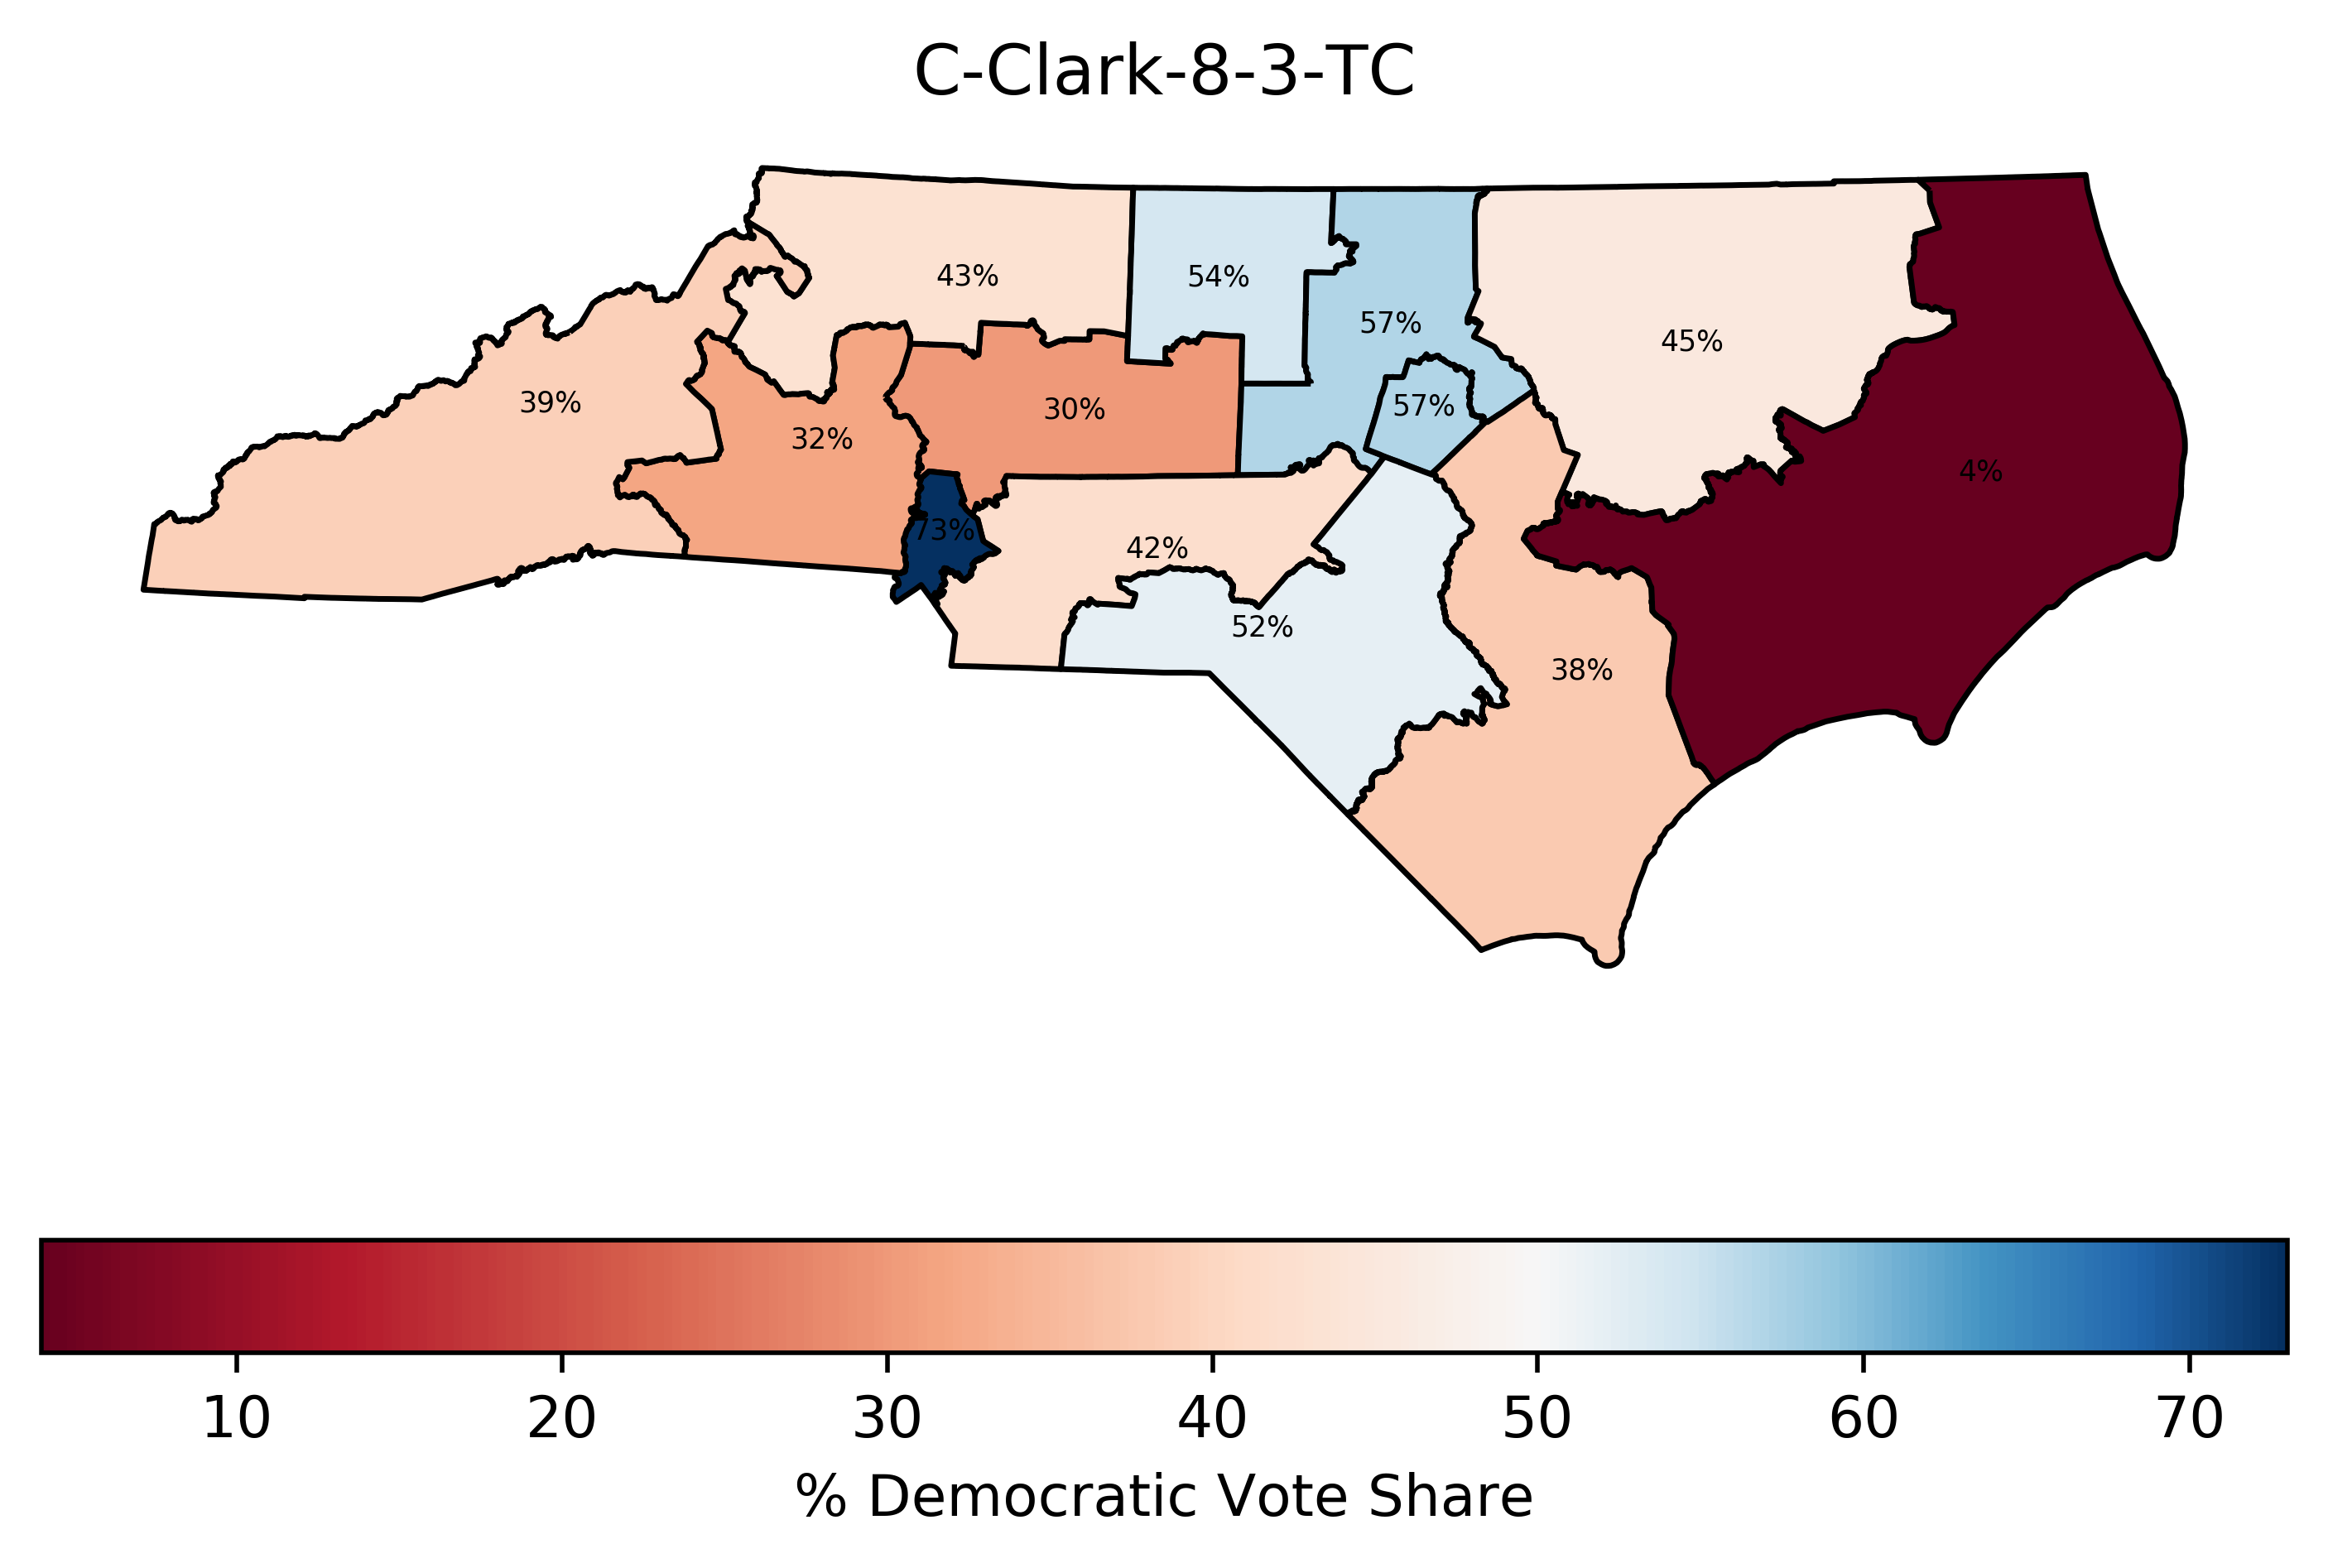

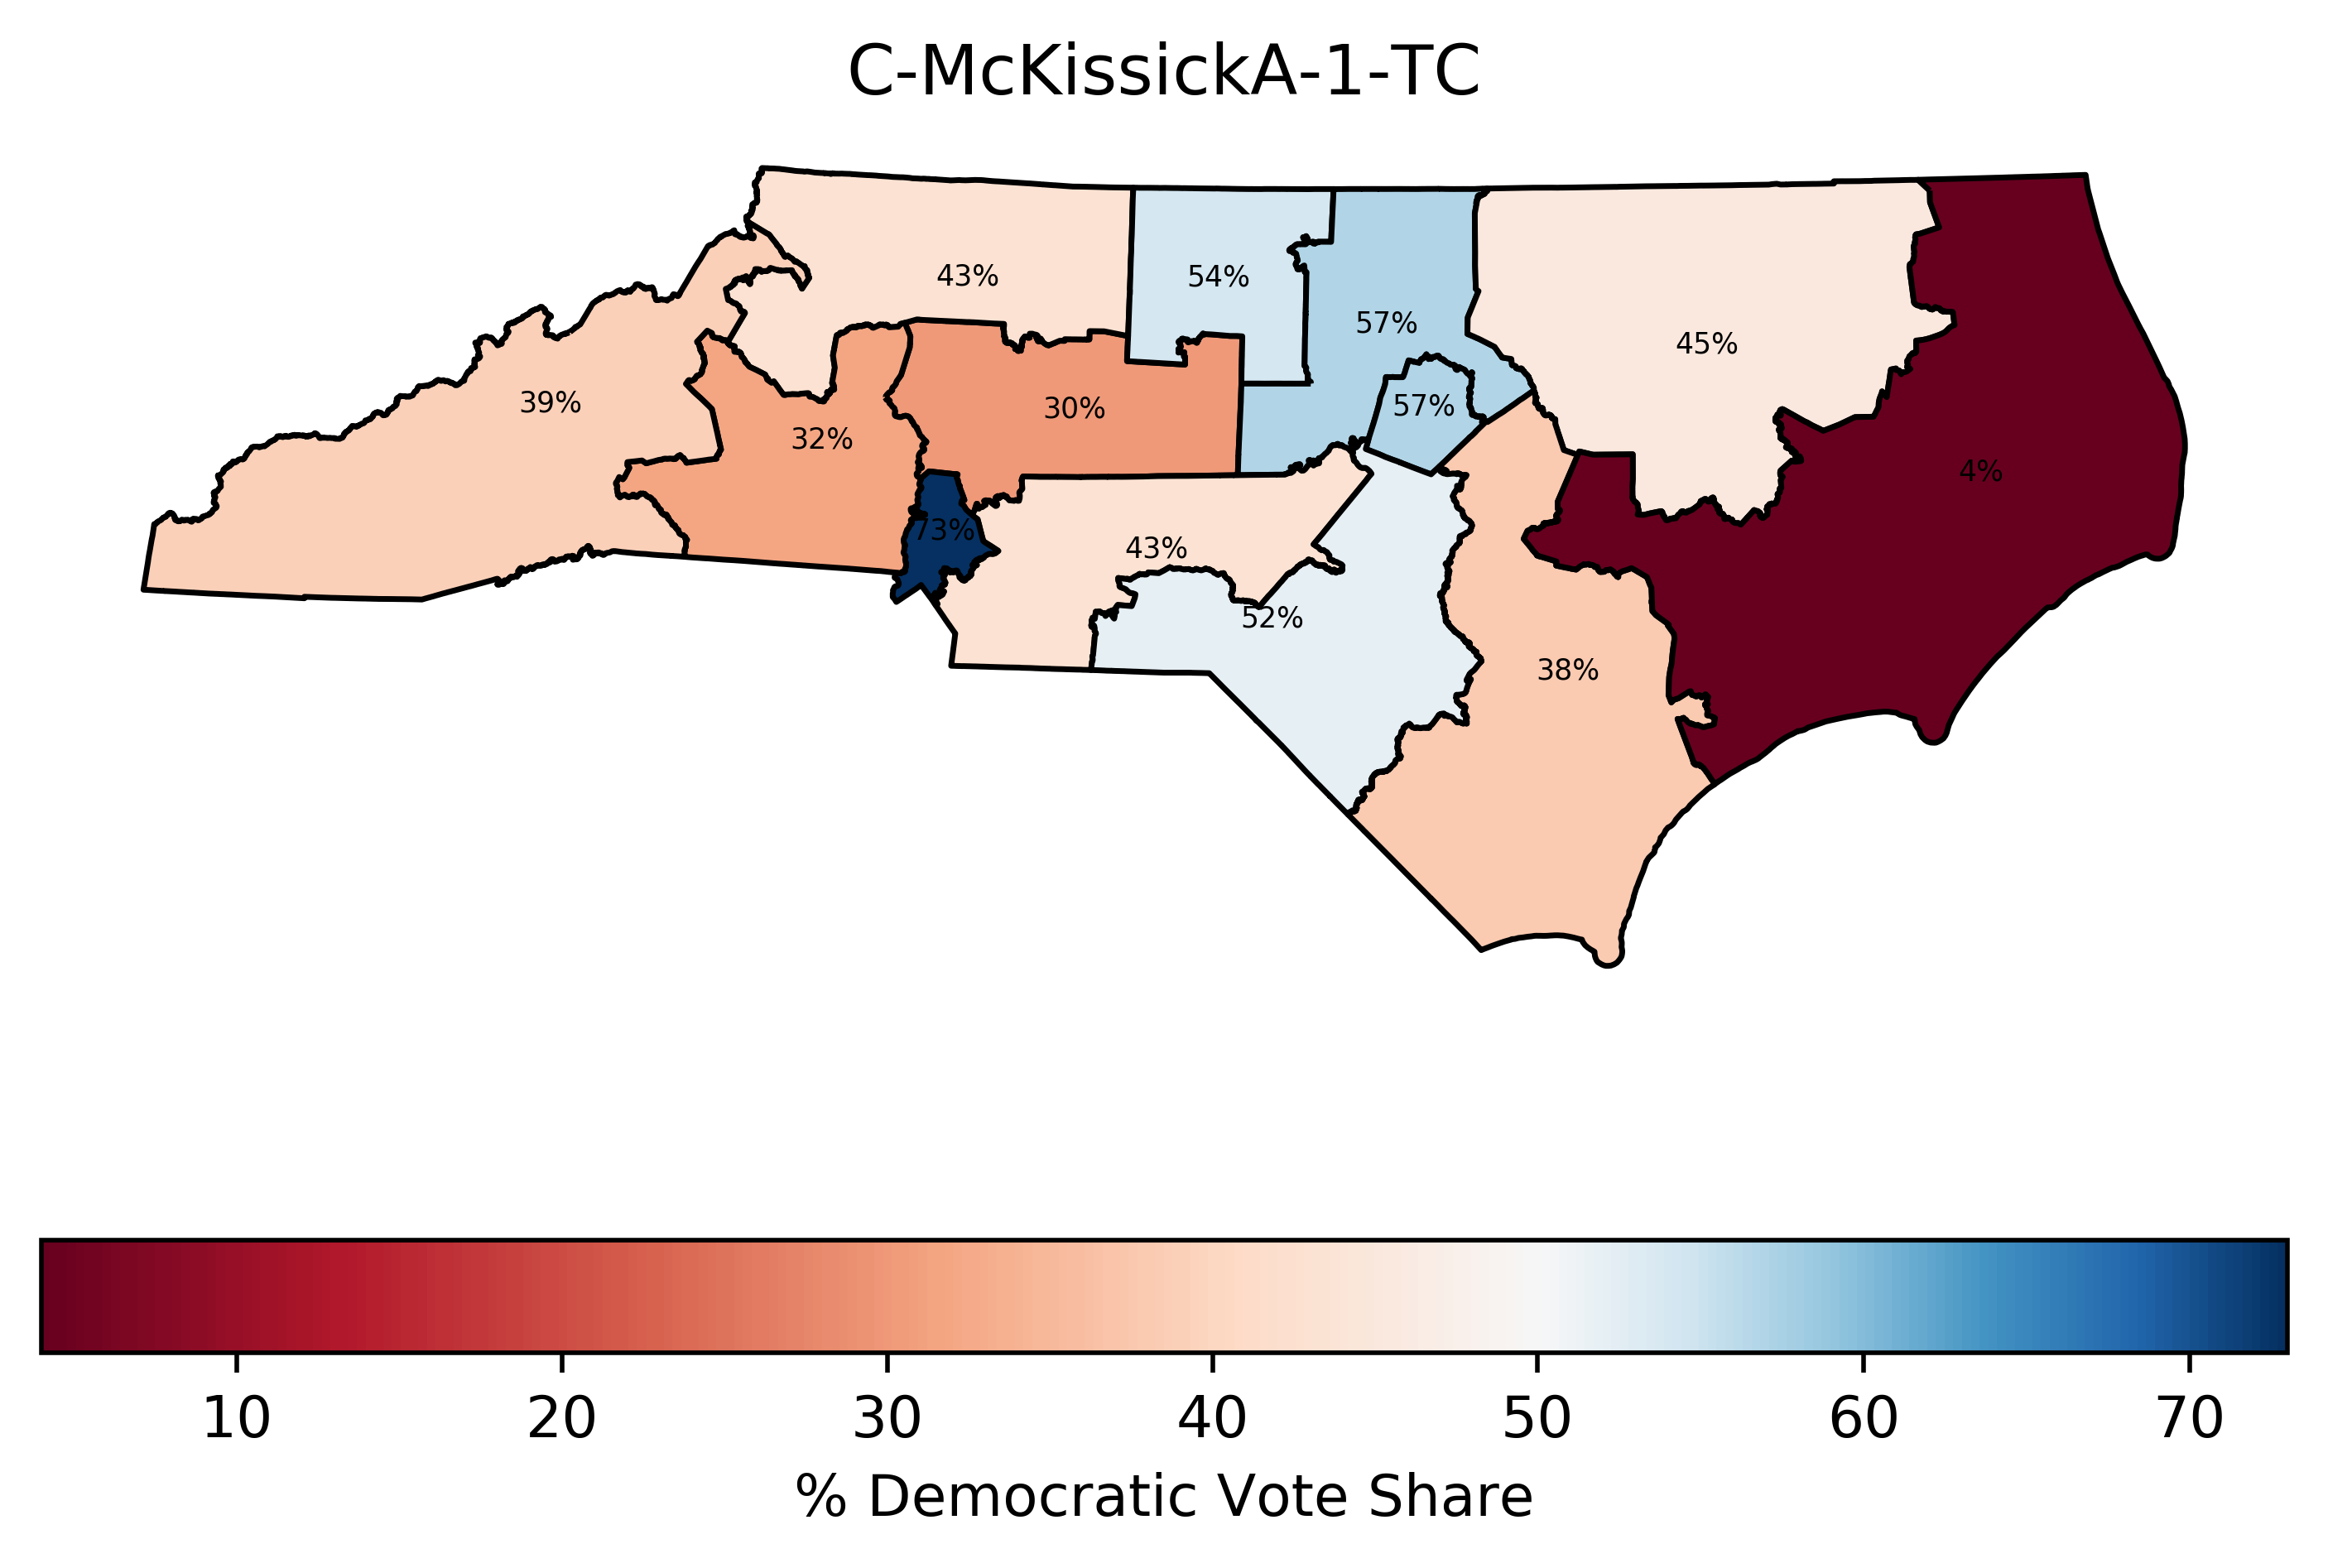

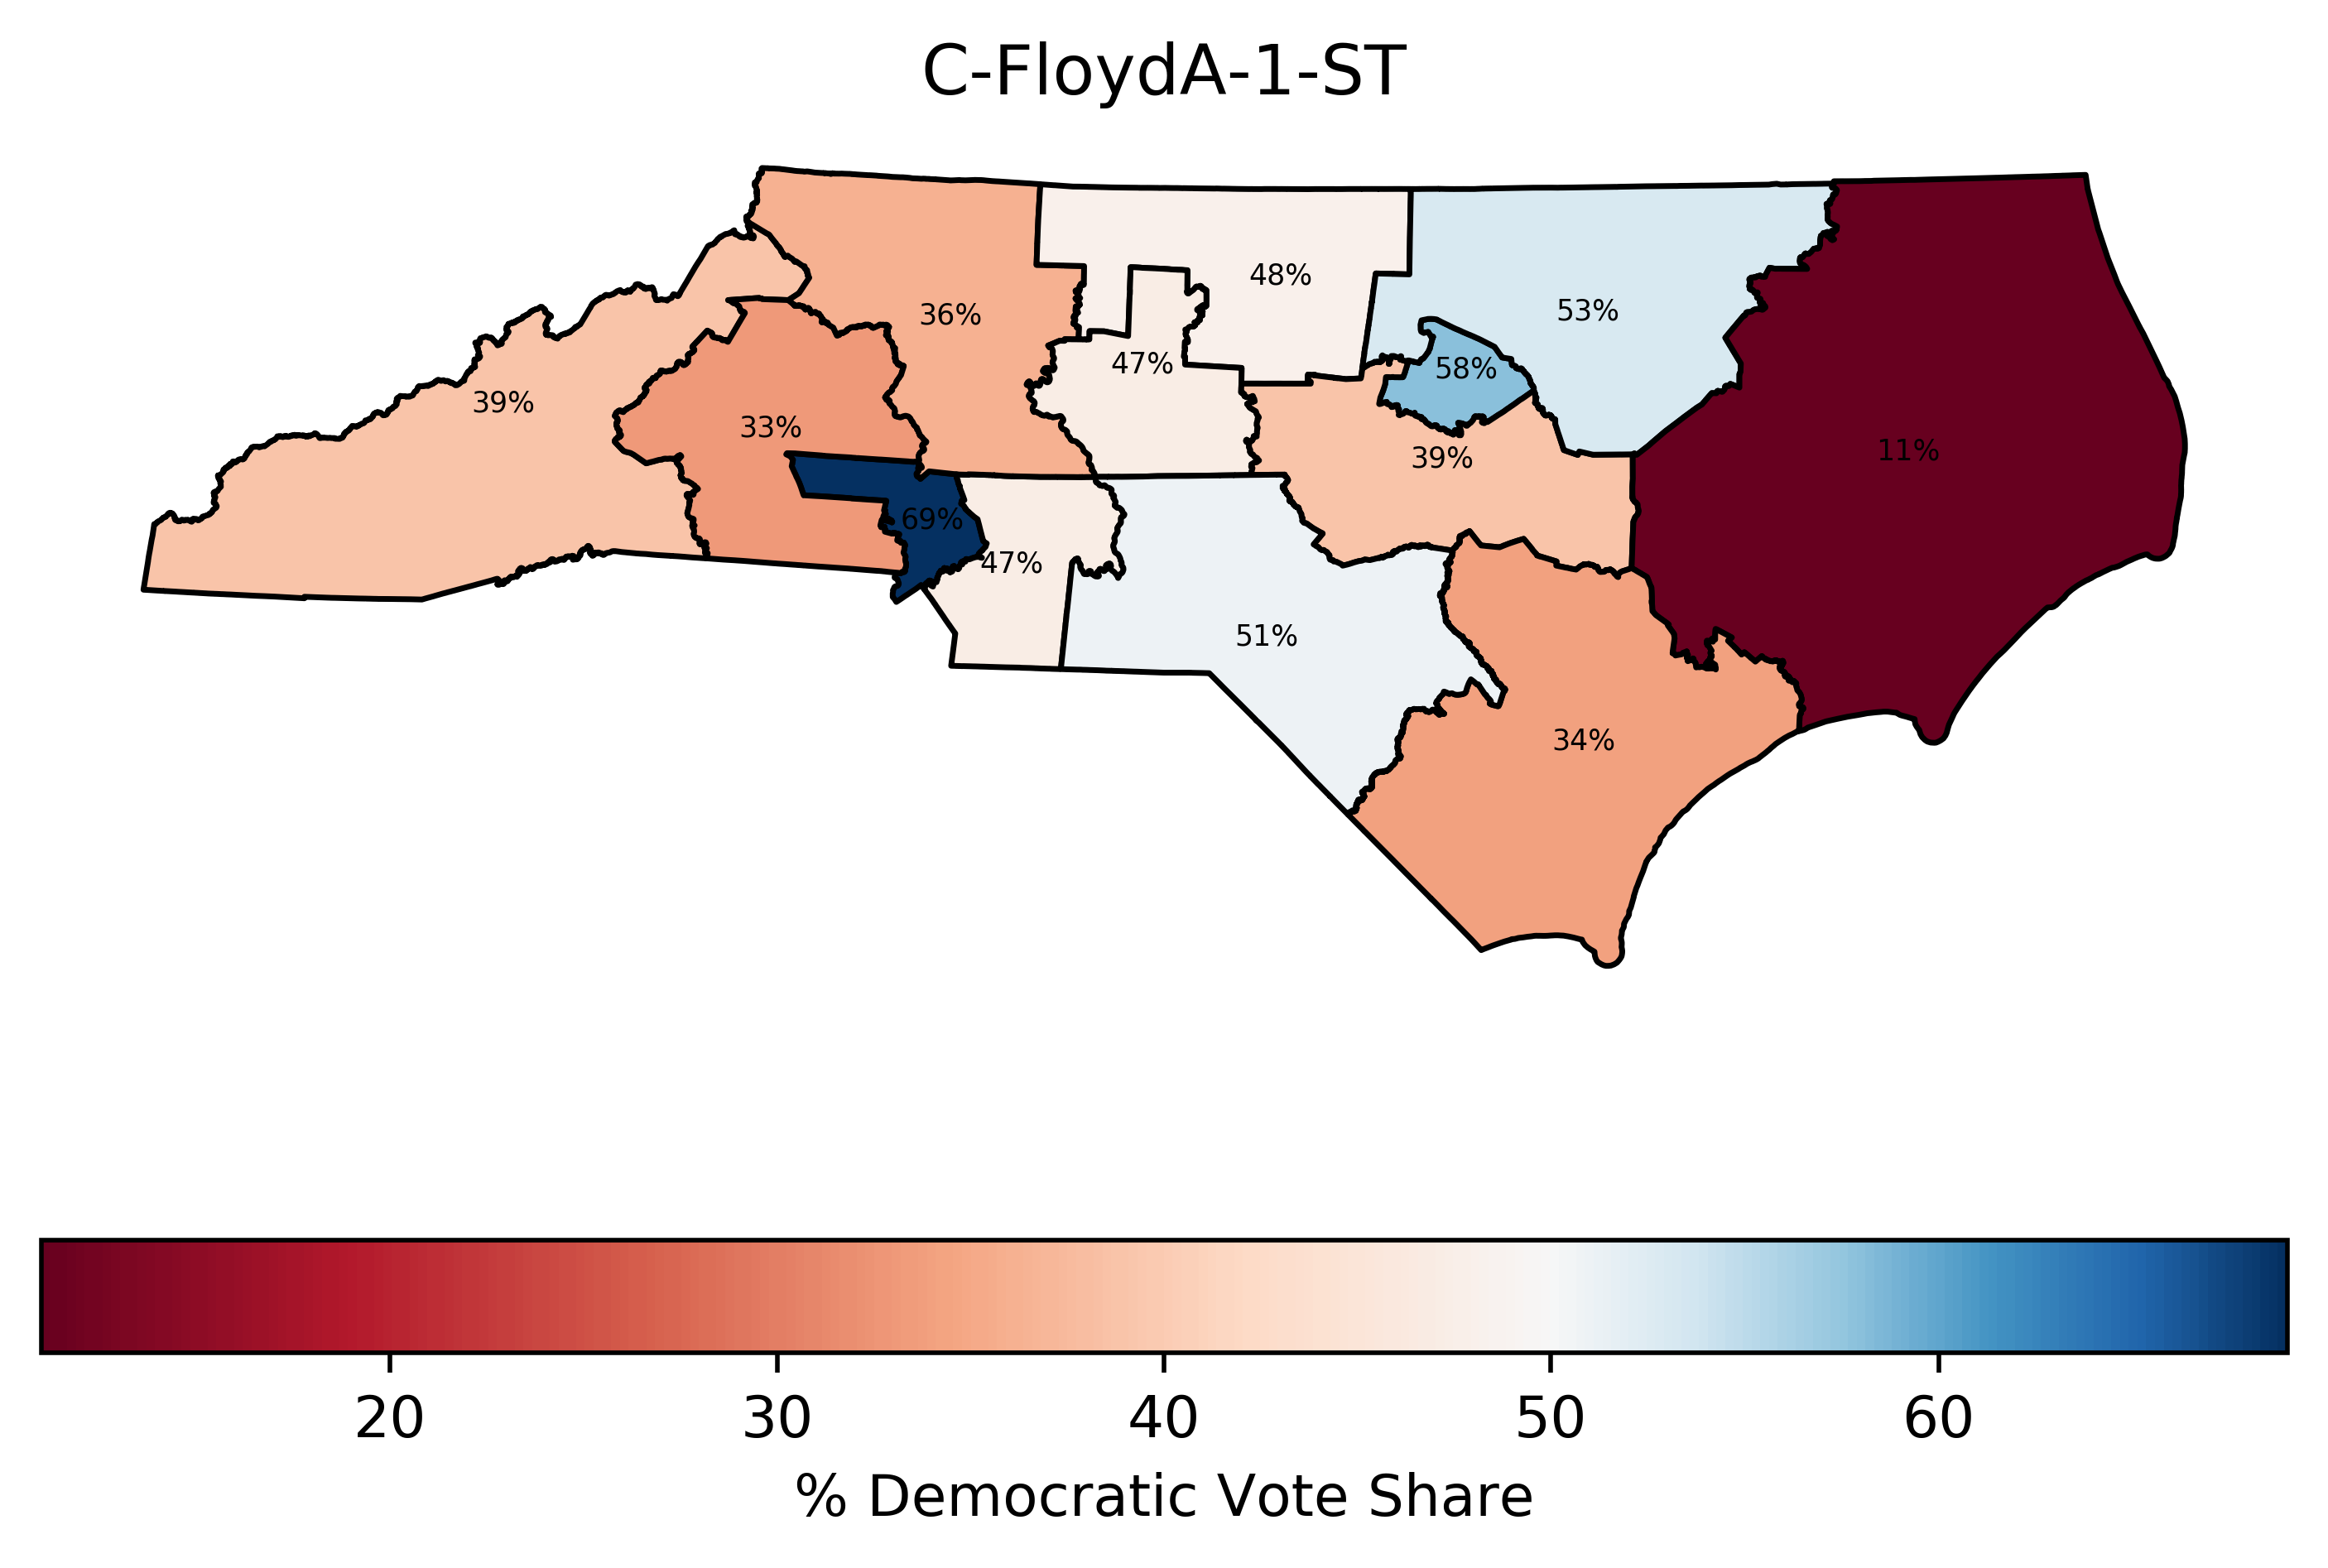

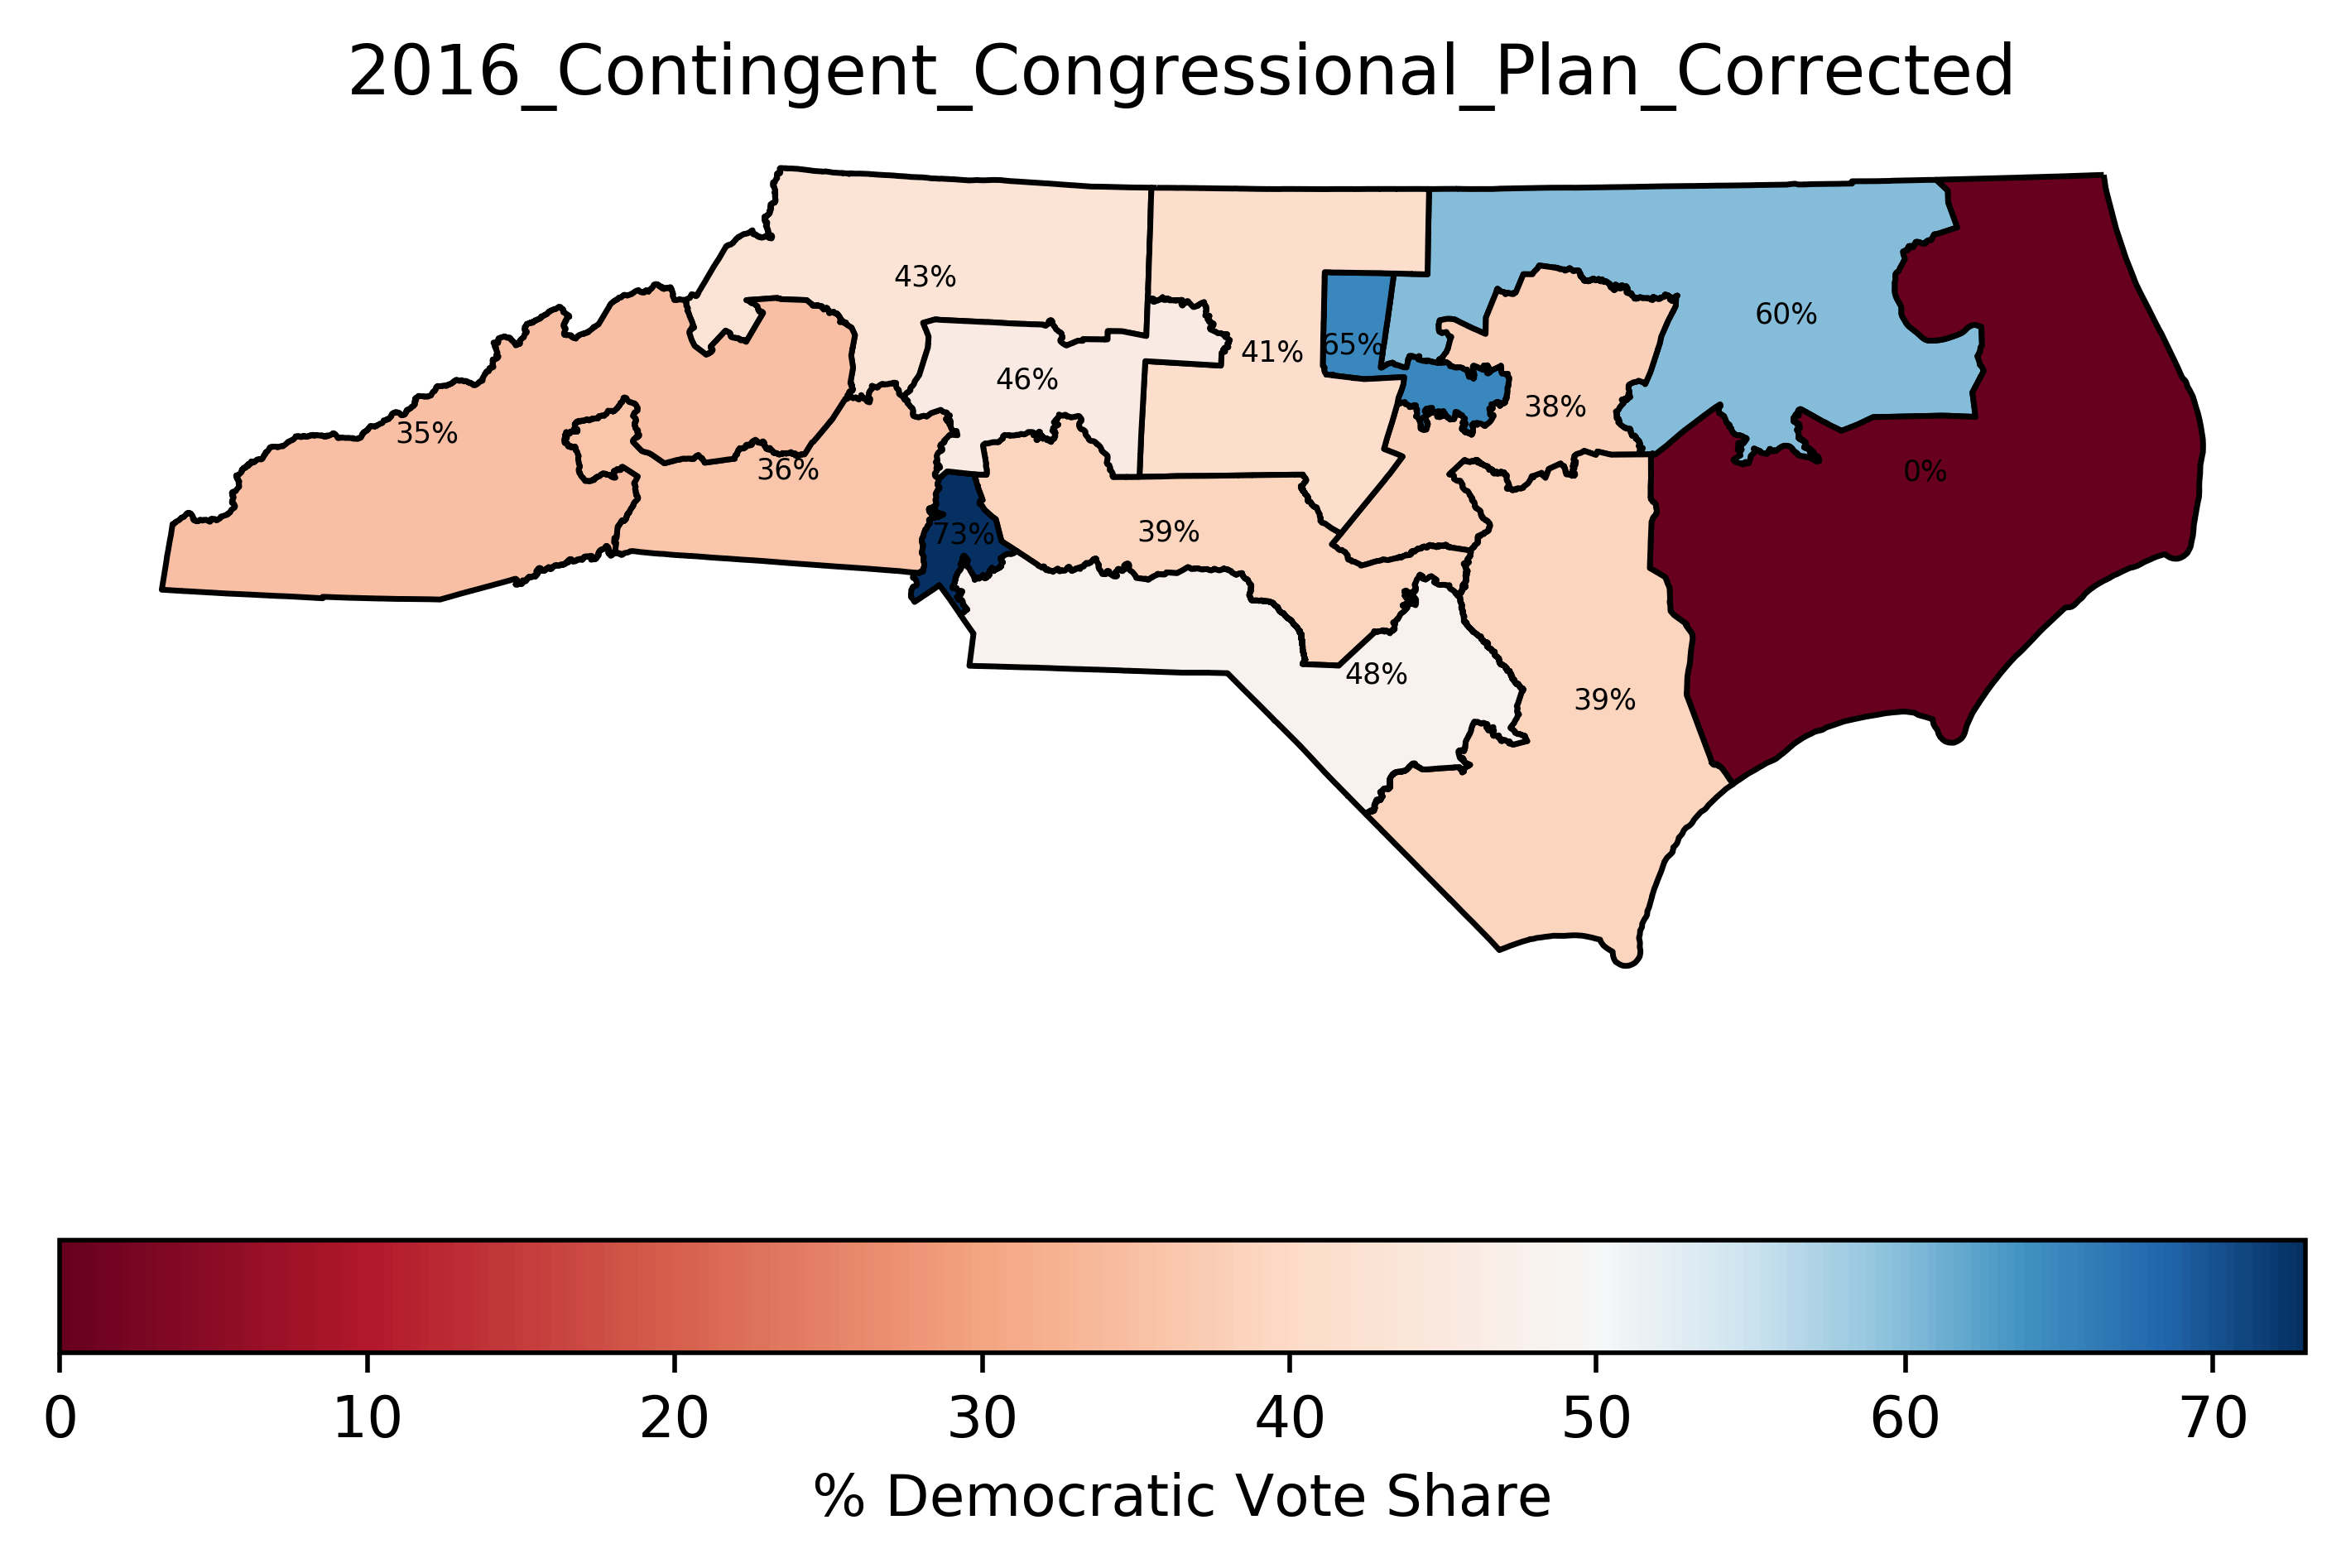

In [35]:
# create a normalized colorbar
divnorm = colors.DivergingNorm(vmin=0, vcenter=50, vmax=100)
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')

# loop through keys in dict, save each plot to a PDF file
for key in files.keys():
    planName = key
    plan = files[planName]
    plan["totVotes"] = plan["G18CHOR"] + plan["G18DHOR"] + plan["G18GHOR"] + plan["G18LHOR"] + plan["G18RHOR"] + plan["G18UnaHOR"]
    plan["percentDem"] = round(plan["G18DHOR"]/plan["totVotes"]*100).astype(np.int64)
    plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])

    plt.rcParams["figure.figsize"] = [7,5]
    plt.rcParams["figure.dpi"] = 500
    plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
    plan['coords'] = [coords[0] for coords in plan['coords']]

    f, ax = plt.subplots(1)
    ax.set_axis_off()
    plan.plot(column="percentDem", ax=ax, edgecolor='black', cmap='RdBu', norm=divnorm)
    for idx, row in plan.iterrows():
        plt.annotate(s=str(row['percentDem'])+"%", xy=row['coords'], horizontalalignment='center', size=5)
    plt.title(planName)
    f.colorbar(cbar, ax=ax, label="% Democratic Vote Share", orientation='horizontal')
    plt.savefig("./plots/NC congressional/"+planName+".pdf", format="pdf")

The plots produced are shown above. If you'd like to save just the plots in a file, run the following code to create a file named "NC congressional plots.pdf" that  contains all the maps.

Notice, the proposed House Bill map we downloaded from ncleg is actually labeled as "C-NewtonA-5-4-TC.shp". 

In [10]:
# get list of all paths of plot pdfs
path = "./plots/NC congressional/"
x = [a for a in os.listdir(path) if a.endswith(".pdf")]
for i in range(len(x)):
    x[i] = path + x[i]
    
# merge all pdfs into one file
merger = PdfFileMerger()
for pdf in x:
    merger.append(open(pdf, 'rb'))

with open("./plots/NC congressional plots.pdf", "wb") as fout:
    merger.write(fout)

# Running Gerrymetrics

This section demonstrates how to apply various gerrymandering tests to the proposed plans using the code implemented in [gerrymandertests](https://github.com/PrincetonUniversity/gerrymandertests).